# Address several basic problems with the data

In [5]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [6]:
data_dir = "./data"
cell_type = "HepG2"
tf = "FOXA1"

## Multi-peak problem

In [7]:
atac_bed_path = [
    f"{data_dir}/{cell_type}/ATAC-seq/{i}"
    for i in os.listdir(f"{data_dir}/{cell_type}/ATAC-seq")
    if i.endswith(".bed")
][0]
# 10 columns
atac_bed = pd.read_table(
    atac_bed_path,
    header=None,
    names=[
        "chrom",
        "chromStart",
        "chromEnd",
        "name",
        "score",
        "strand",
        "signalValue",
        "pValue",
        "qValue",
        "peak",
    ],
    compression="gzip",
).sort_values(["chrom", "chromStart", "chromEnd"], ignore_index=True)
atac_bed["peak_id"] = (
    atac_bed.chrom
    + ":"
    + atac_bed.chromStart.astype(str)
    + "-"
    + atac_bed.chromEnd.astype(str)
)
atac_bed


,chrom,chromStart,chromEnd,name,score,strand,signalValue,pValue,qValue,peak,peak_id
0,chr1,9992,10664,Peak_194613,397,.,3.98088,39.76041,37.89625,511,chr1:9992-10664
1,chr1,180880,181926,Peak_167428,540,.,4.62962,54.03681,52.10256,127,chr1:180880-181926
2,chr1,180880,181926,Peak_202328,367,.,3.83344,36.72277,34.87627,482,chr1:180880-181926
3,chr1,778468,779291,Peak_101849,1000,.,6.64232,135.98801,133.81270,642,chr1:778468-779291
4,chr1,778468,779291,Peak_24591,1000,.,19.34674,750.82861,747.94708,176,chr1:778468-779291
...,...,...,...,...,...,...,...,...,...,...,...
279734,chrY,25394250,25394978,Peak_253410,233,.,3.12573,23.35432,21.60594,415,chrY:25394250-25394978
279735,chrY,25399167,25399394,Peak_211143,337,.,3.68600,33.76786,31.93981,110,chrY:25399167-25399394
279736,chrY,25987793,25988043,Peak_183925,447,.,4.21679,44.78527,42.89428,128,chrY:25987793-25988043
279737,chrY,26315167,26315353,Peak_265193,213,.,3.00778,21.33994,19.61086,90,chrY:26315167-26315353


<AxesSubplot: >

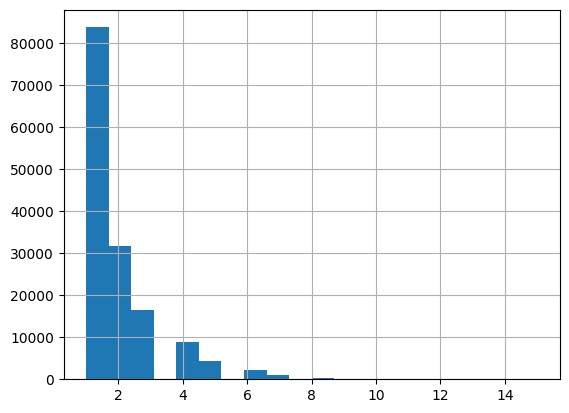

In [8]:
# check if the combination of chrom, chromStart and chromEnd is unique
atac_bed.groupby(["chrom", "chromStart", "chromEnd"]).size().hist(bins=20)

In [9]:
atac_bed.groupby(["chrom", "chromStart", "chromEnd"]).size().sort_values(ascending=False)

chrom  chromStart  chromEnd
chr17  29565732    29569628    15
chr1   91497516    91501746    14
chr7   99141777    99145110    13
chr16  18383981    18388400    13
       16363796    16368165    13
                               ..
chr19  6423557     6423779      1
       6417463     6418412      1
       6357980     6358351      1
       6312016     6312353      1
chrY   26670944    26671507     1
Length: 149268, dtype: int64

In [10]:
atac_bed.peak_id.unique()

array(['chr1:9992-10664', 'chr1:180880-181926', 'chr1:778468-779291', ...,
       'chrY:25987793-25988043', 'chrY:26315167-26315353',
       'chrY:26670944-26671507'], dtype=object)

It seems that for those peaks with multiple entries, these peaks are wide ones merged from several peaks.

In [11]:
# distribution of peak width (do not count one peak multiple times)
peak_id = atac_bed.chrom + ":" + atac_bed.chromStart.astype(str) + "-" + atac_bed.chromEnd.astype(str)
peak_width = atac_bed.chromEnd - atac_bed.chromStart
peak_width = peak_width.groupby(peak_id).first()

<AxesSubplot: >

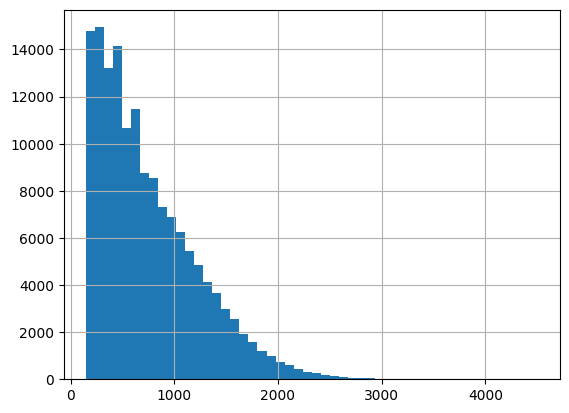

In [12]:
peak_width.hist(bins=50)

In [13]:
peak_width.mean(), peak_width.median(), peak_width.max(), peak_width.min()

(755.2927888093898, 635.0, 4499, 150)

469.51458756117944 408.0 3094 150


<AxesSubplot: >

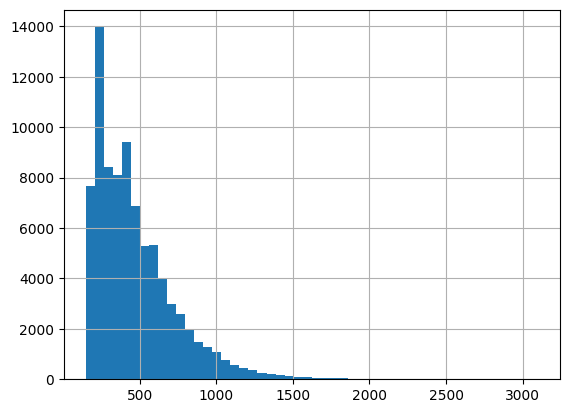

In [14]:
# get those peaks that are only associated with one entry

atac_bed["num_entries"] = atac_bed.groupby("peak_id")["peak_id"].transform("count")

# plot width distribution
peak_width = atac_bed.chromEnd - atac_bed.chromStart
peak_width = peak_width[atac_bed.num_entries == 1]
print(peak_width.mean(), peak_width.median(), peak_width.max(), peak_width.min())
peak_width.hist(bins=50)

In [15]:
# fraction of the genome that are peaks
genome_size_path = "/home/ubuntu/s3/genomes/hg38/hg38.fa.sizes"
genome_size = pd.read_table(genome_size_path, header=None, names=["chrom", "size"])
genome_size

,chrom,size
0,chr1,248956422
1,chr10,133797422
2,chr11,135086622
3,chr12,133275309
4,chr13,114364328
5,chr14,107043718
6,chr15,101991189
7,chr16,90338345
8,chr17,83257441
9,chr18,80373285


In [16]:
atac_bed_dedup = atac_bed.drop_duplicates("peak_id")
atac_bed_dedup

,chrom,chromStart,chromEnd,name,score,strand,signalValue,pValue,qValue,peak,peak_id,num_entries
0,chr1,9992,10664,Peak_194613,397,.,3.98088,39.76041,37.89625,511,chr1:9992-10664,1
1,chr1,180880,181926,Peak_167428,540,.,4.62962,54.03681,52.10256,127,chr1:180880-181926,2
3,chr1,778468,779291,Peak_101849,1000,.,6.64232,135.98801,133.81270,642,chr1:778468-779291,3
6,chr1,804535,805007,Peak_188827,422,.,4.09884,42.24806,40.37027,355,chr1:804535-805007,1
7,chr1,826578,828134,Peak_197490,385,.,2.25427,38.59490,36.73744,104,chr1:826578-828134,5
...,...,...,...,...,...,...,...,...,...,...,...,...
279734,chrY,25394250,25394978,Peak_253410,233,.,3.12573,23.35432,21.60594,415,chrY:25394250-25394978,1
279735,chrY,25399167,25399394,Peak_211143,337,.,3.68600,33.76786,31.93981,110,chrY:25399167-25399394,1
279736,chrY,25987793,25988043,Peak_183925,447,.,4.21679,44.78527,42.89428,128,chrY:25987793-25988043,1
279737,chrY,26315167,26315353,Peak_265193,213,.,3.00778,21.33994,19.61086,90,chrY:26315167-26315353,1


In [17]:
peak_size = {i: 0 for i in genome_size.chrom}
for i in tqdm(genome_size.itertuples(), total=genome_size.shape[0]):
    peak_cover = np.zeros(i.size)
    atac_bed_dedup_chr = atac_bed_dedup.query(f"chrom == '{i.chrom}'")
    for j in atac_bed_dedup_chr.itertuples():
        peak_cover[j.chromStart : j.chromEnd] += 1
    assert peak_cover.max() <= 1
    peak_size[i.chrom] = peak_cover.astype(bool).sum()


  0%|          | 0/25 [00:00<?, ?it/s]

<AxesSubplot: >

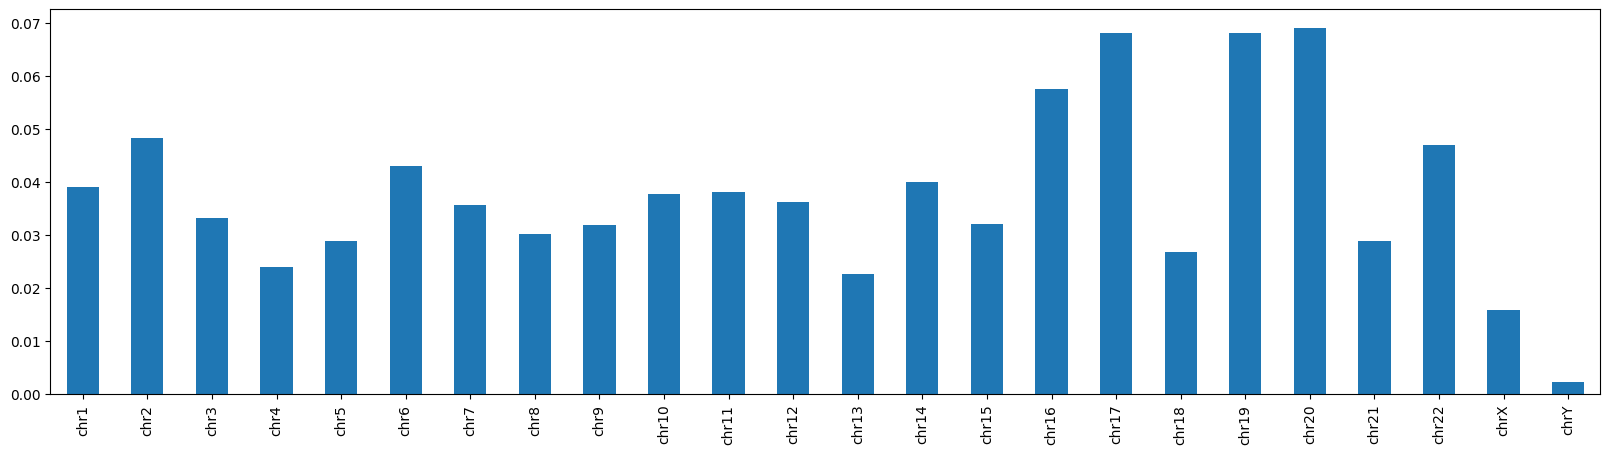

In [18]:
# plot for each chromosome fraction of the genome that are peaks
fig, ax = plt.subplots(figsize=(20, 5))
frac = {}
for i in genome_size.itertuples():
    if peak_size[i.chrom] == 0:
        continue
    frac[i.chrom] = peak_size[i.chrom] / i.size
chr_id  = list(map(lambda x: int(x[3:]) if x[3:].isdigit() else ord(x[3:]), frac.keys()))
pd.Series(frac)[np.argsort(chr_id)].plot.bar(ax=ax)

### Do the same analysis for the TF ChIP-seq data

In [19]:
# do the same analysis for the TF ChIP-seq data
tf_bed_path = [
    f"{data_dir}/{cell_type}/{tf}/{i}"
    for i in os.listdir(f"{data_dir}/{cell_type}/{tf}")
    if i.endswith(".bed")
][0]
# 10 columns
tf_bed = pd.read_table(
    tf_bed_path,
    header=None,
    names=[
        "chrom",
        "chromStart",
        "chromEnd",
        "name",
        "score",
        "strand",
        "signalValue",
        "pValue",
        "qValue",
        "peak",
    ],
    compression="gzip",
).sort_values(["chrom", "chromStart", "chromEnd"], ignore_index=True)
tf_bed["peak_id"] = (
    tf_bed.chrom
    + ":"
    + tf_bed.chromStart.astype(str)
    + "-"
    + tf_bed.chromEnd.astype(str)
)
tf_bed


,chrom,chromStart,chromEnd,name,score,strand,signalValue,pValue,qValue,peak,peak_id
0,chr1,1360864,1361208,.,661,.,36.92105,-1.0,1.64529,172,chr1:1360864-1361208
1,chr1,1400836,1401180,.,1000,.,84.44192,-1.0,2.39847,172,chr1:1400836-1401180
2,chr1,2134676,2135020,.,592,.,36.73038,-1.0,1.62897,172,chr1:2134676-2135020
3,chr1,3624607,3624951,.,1000,.,67.64939,-1.0,2.39847,172,chr1:3624607-3624951
4,chr1,4336545,4336889,.,618,.,35.87511,-1.0,1.57145,172,chr1:4336545-4336889
...,...,...,...,...,...,...,...,...,...,...,...
7144,chrY,26669233,26669577,.,1000,.,39.85377,-1.0,1.79642,172,chrY:26669233-26669577
7145,chrY,26670358,26670528,.,1000,.,98.60133,-1.0,2.39847,89,chrY:26670358-26670528
7146,chrY,26671033,26671164,.,1000,.,113.50800,-1.0,2.39847,43,chrY:26671033-26671164
7147,chrY,26671526,26671870,.,671,.,42.72746,-1.0,1.93320,172,chrY:26671526-26671870


In [20]:
tf_bed.peak_id.unique().shape

(7148,)

<AxesSubplot: >

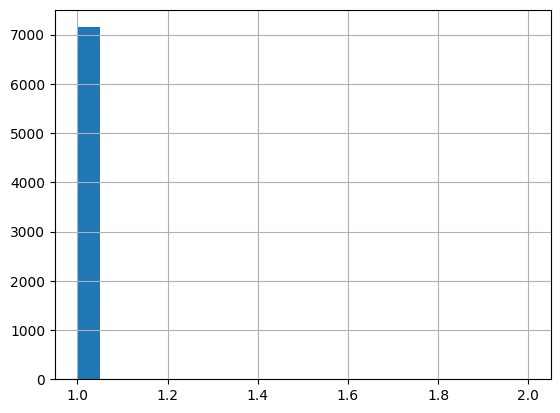

In [21]:
tf_bed.groupby("peak_id").size().hist(bins=20)

(318.2124772695482, 344.0, 821, 86)

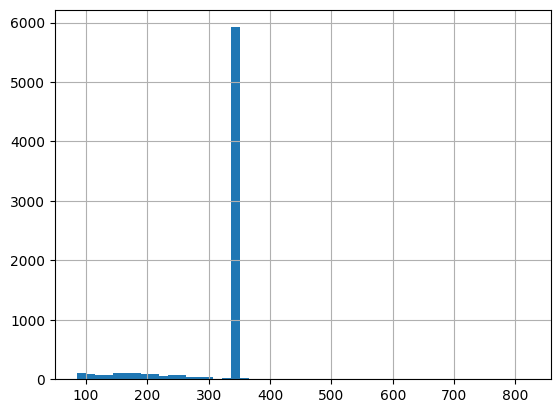

In [22]:
peak_width = tf_bed.chromEnd - tf_bed.chromStart
peak_width.groupby(tf_bed.peak_id).first().hist(bins=50)
peak_width.mean(), peak_width.median(), peak_width.max(), peak_width.min()


318.07177836854623 344.0 605 86


<AxesSubplot: >

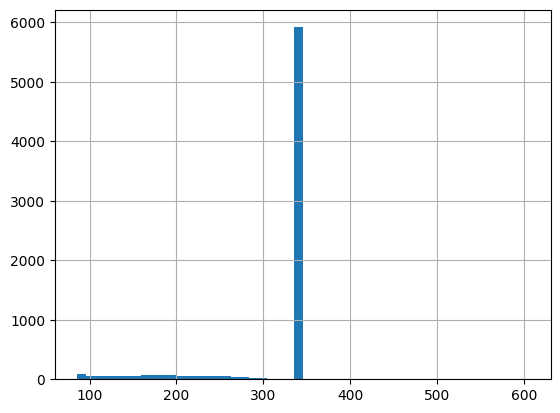

In [23]:
tf_bed["num_entries"] = tf_bed.groupby("peak_id")["peak_id"].transform("count")
peak_width = peak_width[tf_bed.num_entries == 1]
print(peak_width.mean(), peak_width.median(), peak_width.max(), peak_width.min())
peak_width.hist(bins=50)

In [24]:
# fraction of the genome that are peaks
genome_size_path = "/home/ubuntu/s3/genomes/hg38/hg38.fa.sizes"
genome_size = pd.read_table(genome_size_path, header=None, names=["chrom", "size"])

tf_bed_dedup = tf_bed.drop_duplicates("peak_id")

peak_size = {i: 0 for i in genome_size.chrom}
for i in tqdm(genome_size.itertuples(), total=genome_size.shape[0]):
    peak_cover = np.zeros(i.size)
    tf_bed_dedup_chr = tf_bed_dedup.query(f"chrom == '{i.chrom}'")
    for j in tf_bed_dedup_chr.itertuples():
        peak_cover[j.chromStart : j.chromEnd] += 1
    print((peak_cover > 1).sum(), peak_cover.astype(bool).sum())
    peak_size[i.chrom] = peak_cover.astype(bool).sum()


# plot for each chromosome fraction of the genome that are peaks
frac = {}
for i in genome_size.itertuples():
    if peak_size[i.chrom] == 0:
        continue
    frac[i.chrom] = peak_size[i.chrom] / i.size
chr_id = list(map(lambda x: int(x[3:]) if x[3:].isdigit() else ord(x[3:]), frac.keys()))

  0%|          | 0/25 [00:00<?, ?it/s]

693 147746
661 91655
564 77520
709 83356
261 40859
1947 145209
285 45684
2174 140642
2291 113606
285 42580
606 50260
2970 290773
3149 164037
283 27305
274 38481
282 119531
268 81310
644 88356
2265 171940
661 99025
780 91715
809 71632
0 0
0 25632
0 2365


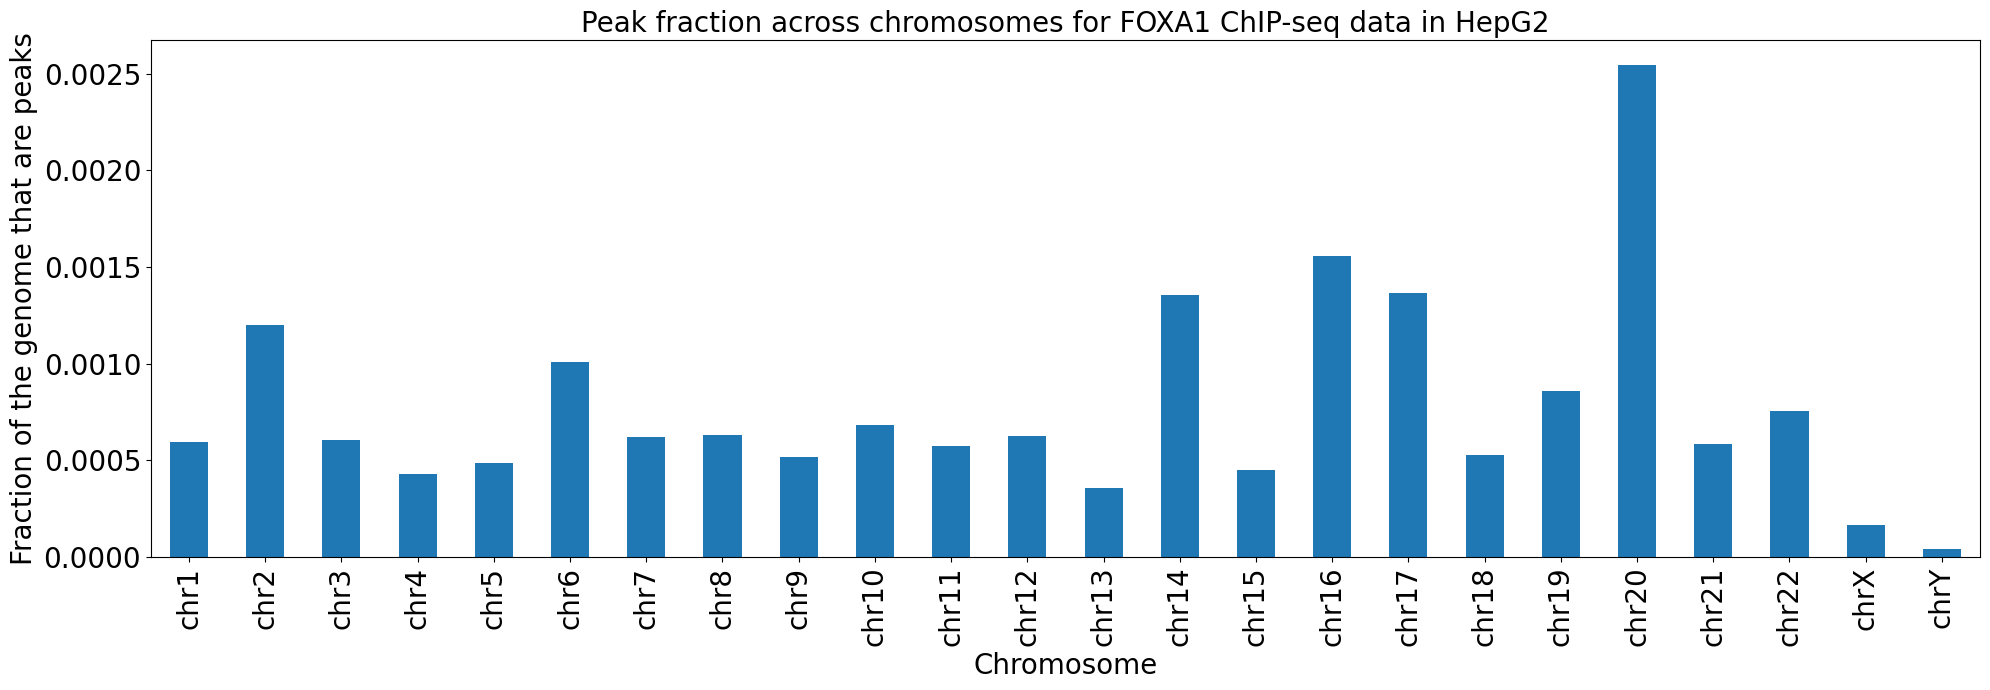

In [25]:
fig, ax = plt.subplots(figsize=(20, 7))
pd.Series(frac)[np.argsort(chr_id)].plot.bar(ax=ax)
# set reasonable axis names and title, make axis and tick label font larger
ax.set_xlabel("Chromosome", fontsize=20)
ax.set_ylabel("Fraction of the genome that are peaks", fontsize=20)
ax.set_title(
    f"Peak fraction across chromosomes for {tf} ChIP-seq data in {cell_type}",
    fontsize=20,
)
ax.tick_params(axis="both", which="major", labelsize=20)
fig.tight_layout()

### Do the same thing for motif

In [26]:
motif_data_dir = "./data_jaspar/track/hg38"
profile = "MA0148.4"
motif_bed_path = f"{motif_data_dir}/{profile}.bed"
# 6 columns
motif_bed = pd.read_table(
    motif_bed_path,
    header=None,
    names=["chrom", "chromStart", "chromEnd", "name", "score", "strand"],
)
motif_pos_bed, motif_neg_bed = (
    motif_bed[motif_bed.strand == "+"],
    motif_bed[motif_bed.strand == "-"],
)

In [27]:
# no need to plot motif length since it is fixed.
# also no need to drop duplicates since there are no duplicates
# let go directly to the fraction of the genome that are motifs
genome_size_path = "/home/ubuntu/s3/genomes/hg38/hg38.fa.sizes"
genome_size = pd.read_table(genome_size_path, header=None, names=["chrom", "size"])

motif_size_pos = {i: 0 for i in genome_size.chrom}
motif_size_neg = {i: 0 for i in genome_size.chrom}
motif_size_either = {i: 0 for i in genome_size.chrom}
for i in tqdm(genome_size.itertuples(), total=genome_size.shape[0]):
    motif_cover_pos = np.zeros(i.size)
    motif_cover_neg = np.zeros(i.size)
    motif_bed_pos_chr = motif_pos_bed.query(f"chrom == '{i.chrom}'")
    motif_bed_neg_chr = motif_neg_bed.query(f"chrom == '{i.chrom}'")
    for j in motif_bed_pos_chr.itertuples():
        motif_cover_pos[j.chromStart : j.chromEnd] += 1
    for j in motif_bed_neg_chr.itertuples():
        motif_cover_neg[j.chromStart : j.chromEnd] += 1
    motif_cover_either = motif_cover_pos + motif_cover_neg
    print(
        (motif_cover_pos > 1).sum(),
        (motif_cover_neg > 1).sum(),
        (motif_cover_either > 1).sum(),
        motif_cover_pos.astype(bool).sum(),
        motif_cover_neg.astype(bool).sum(),
        motif_cover_either.astype(bool).sum(),
    )

    motif_size_pos[i.chrom] = motif_cover_pos.astype(bool).sum()
    motif_size_neg[i.chrom] = motif_cover_neg.astype(bool).sum()
    motif_size_either[i.chrom] = motif_cover_either.astype(bool).sum()

# plot for each chromosome fraction of the genome that are motifs (this time there will be 3 bars per chromosome)
frac_pos = {}
frac_neg = {}
frac_either = {}
for i in genome_size.itertuples():
    if motif_size_either[i.chrom] == 0:
        continue
    frac_pos[i.chrom] = motif_size_pos[i.chrom] / i.size
    frac_neg[i.chrom] = motif_size_neg[i.chrom] / i.size
    frac_either[i.chrom] = motif_size_either[i.chrom] / i.size

chr_id = list(map(lambda x: int(x[3:]) if x[3:].isdigit() else ord(x[3:]), frac_pos.keys()))

  0%|          | 0/25 [00:00<?, ?it/s]

188031 187030 1445364 7047365 6985493 12875161
106075 108837 847315 4178047 4109531 7602583
104847 104917 844923 4172707 4169451 7653554
113666 115657 864199 4279774 4244935 7833111
92490 92439 704246 3611817 3653155 6696471
72175 75300 582424 2887090 2951540 5367788
65863 66416 517549 2543960 2599039 4726425
63963 63474 480935 2144610 2140332 3903013
64258 61969 452441 2031929 2049229 3730167
68846 64702 523842 2729772 2863054 5167836
47094 47699 302277 1269183 1213638 2260393
203411 204470 1611619 8018578 8058972 14769341
44498 46513 369483 1793274 1765540 3260299
32531 32630 259832 1328177 1345913 2463581
25639 25864 202927 899550 914734 1652891
168092 169099 1324380 6741735 6727282 12396106
178926 175113 1355249 6983199 7029889 12918227
153398 155630 1229334 6260245 6221312 11482237
147494 147965 1155674 5847809 5866977 10780594
136182 139219 1040628 5183079 5130903 9481194
122626 121018 961600 4870409 4849456 8940664
96248 95399 771595 3862980 3885793 7121096
0 0 17 281 238 502
13

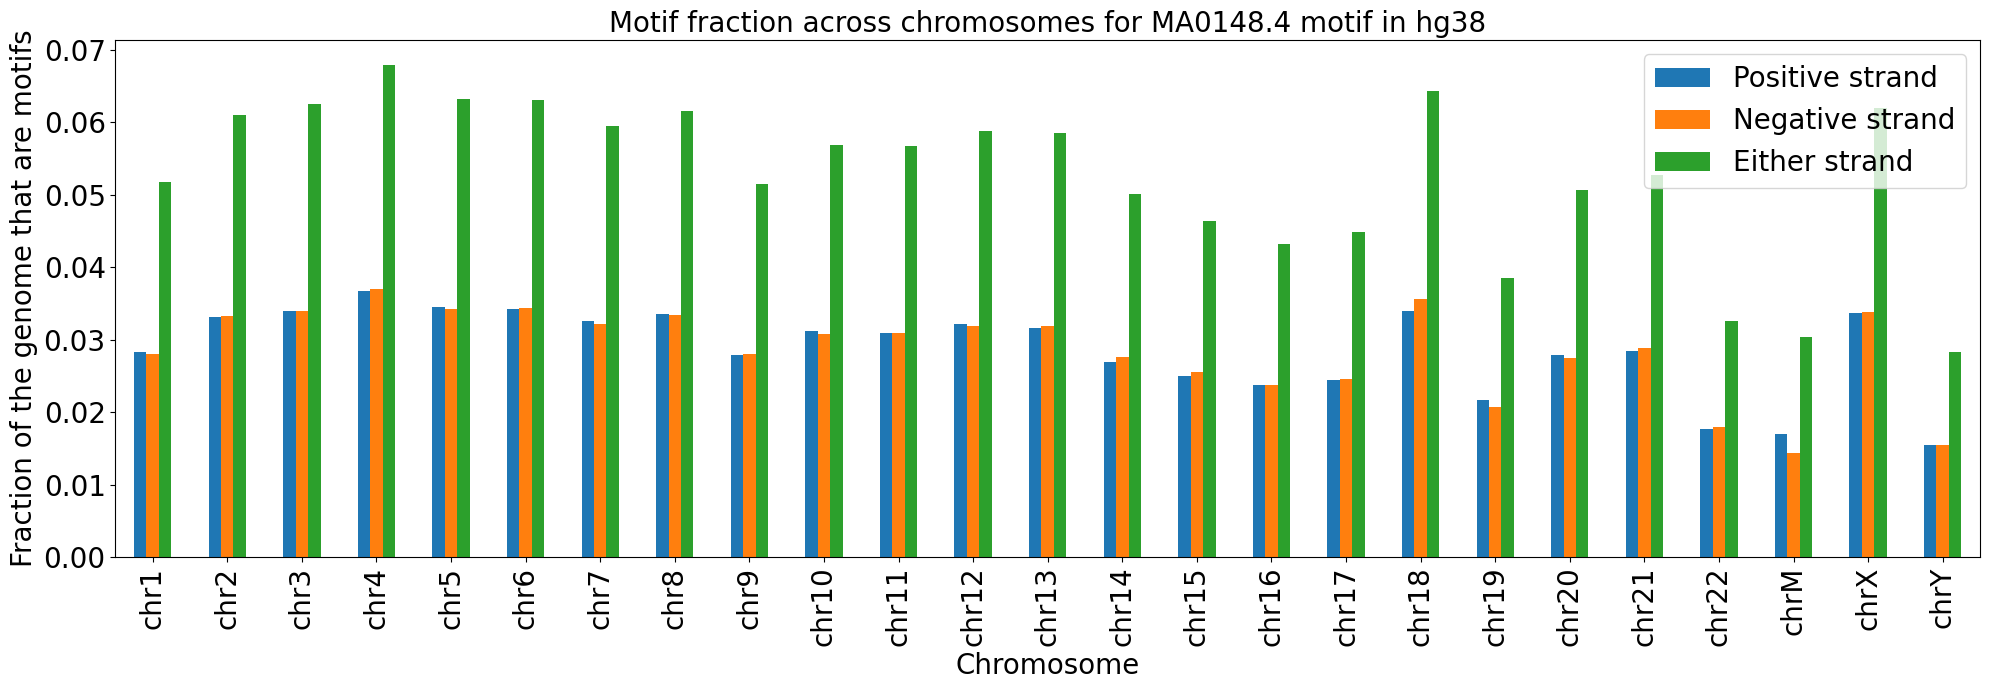

In [28]:
fig, ax = plt.subplots(figsize=(20, 7))

pd.DataFrame(
    {
        "Positive strand": pd.Series(frac_pos)[np.argsort(chr_id)],
        "Negative strand": pd.Series(frac_neg)[np.argsort(chr_id)],
        "Either strand": pd.Series(frac_either)[np.argsort(chr_id)],
    }
).plot.bar(ax=ax)

# set reasonable axis names and title, make axis and tick label font larger
ax.set_xlabel("Chromosome", fontsize=20)
ax.set_ylabel("Fraction of the genome that are motifs", fontsize=20)
ax.set_title(
    f"Motif fraction across chromosomes for {profile} motif in hg38",
    fontsize=20,
)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.legend(fontsize=20)
fig.tight_layout()

## Are the distribution of ATAC-seq peaks independent of the distribution of motifs?

In [29]:
motif_length = (motif_bed.chromEnd - motif_bed.chromStart).iloc[0]

motif_length

12

In [30]:
# for each chromosome, plot the fraction of the peaks that have a motif, and the fraction that are not peaks but also have a motif

# first, get the number of peaks that have a motif
peak_motif = {i: 0 for i in genome_size.chrom}
non_peak_motif = {i: 0 for i in genome_size.chrom}
peak_size = {i: 0 for i in genome_size.chrom}
non_peak_size = {i: 0 for i in genome_size.chrom}
for i in tqdm(genome_size.itertuples(), total=genome_size.shape[0]):
    motif_cover_pos = np.zeros(i.size, dtype=bool)
    motif_cover_neg = np.zeros(i.size, dtype=bool)
    peak_cover = np.zeros(i.size, dtype=bool)
    motif_bed_pos_chr = motif_pos_bed.query(f"chrom == '{i.chrom}'")
    motif_bed_neg_chr = motif_neg_bed.query(f"chrom == '{i.chrom}'")
    atac_bed_dedup_chr = atac_bed_dedup.query(f"chrom == '{i.chrom}'")
    for j in motif_bed_pos_chr.itertuples():
        motif_cover_pos[j.chromStart : j.chromEnd] = True
    for j in motif_bed_neg_chr.itertuples():
        motif_cover_neg[j.chromStart : j.chromEnd] = True
    for j in atac_bed_dedup_chr.itertuples():
        peak_cover[j.chromStart : j.chromEnd] = True
    motif_cover_either = motif_cover_pos | motif_cover_neg
    peak_motif[i.chrom] = (peak_cover & motif_cover_either).sum()
    non_peak_motif[i.chrom] = (~peak_cover & motif_cover_either).sum()
    peak_size[i.chrom] = peak_cover.sum()
    non_peak_size[i.chrom] = (~peak_cover).sum()

frac_peak = {}
frac_non_peak = {}
for i in genome_size.itertuples():
    if peak_motif[i.chrom] == 0:
        continue
    frac_peak[i.chrom] = peak_motif[i.chrom] / peak_size[i.chrom]
    frac_non_peak[i.chrom] = non_peak_motif[i.chrom] / non_peak_size[i.chrom]
    
chr_id = list(
    map(lambda x: int(x[3:]) if x[3:].isdigit() else ord(x[3:]), frac_peak.keys())
)


  0%|          | 0/25 [00:00<?, ?it/s]

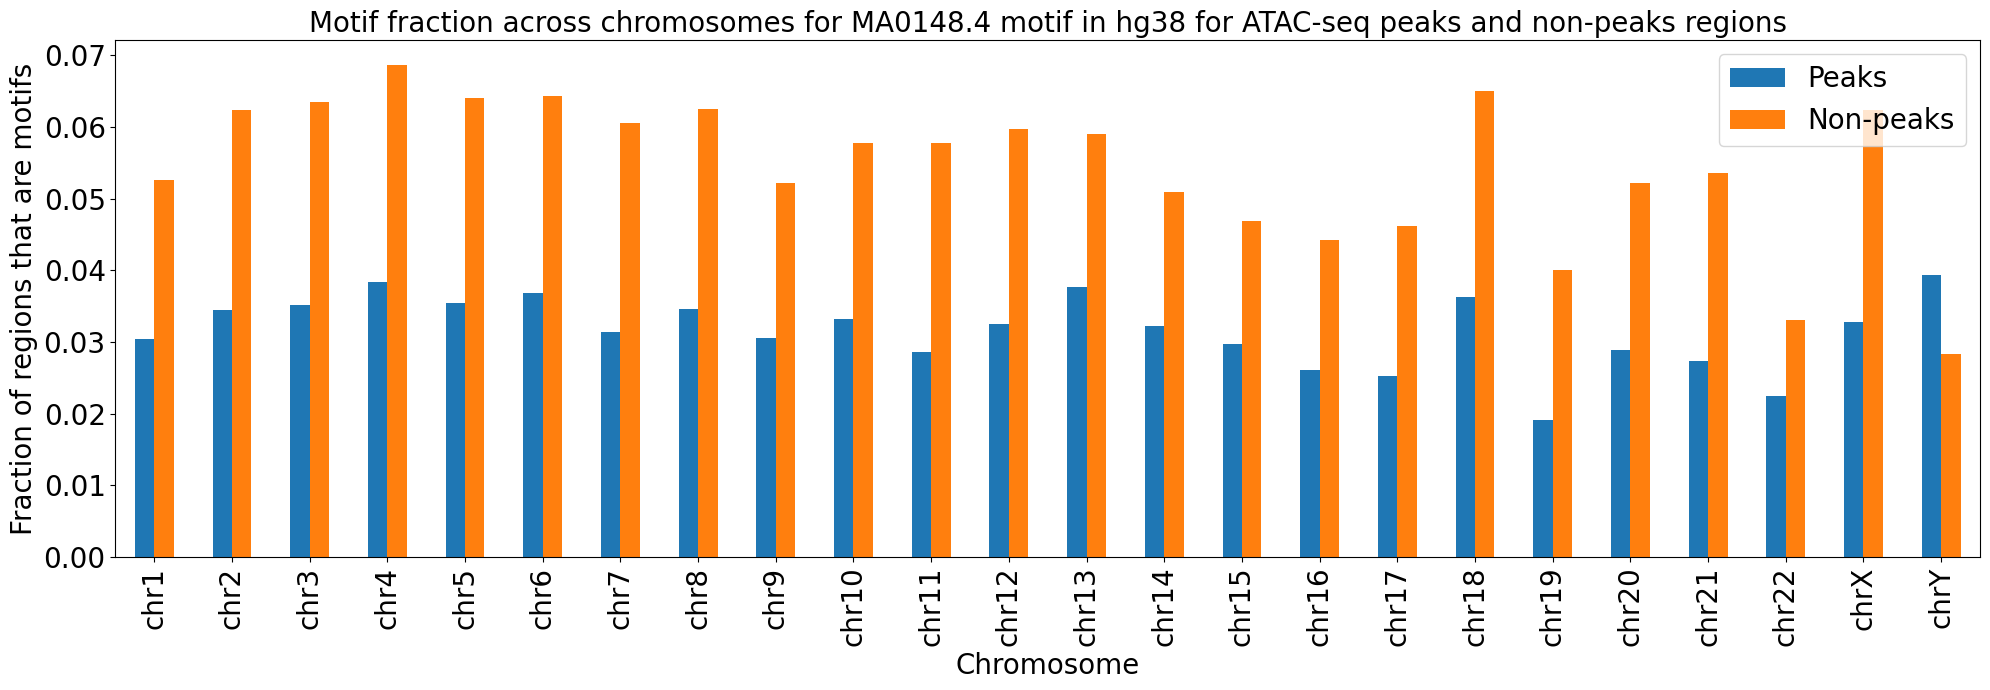

In [31]:
# each chromosome will have 2 bars, one for peaks and one for non peaks
fig, ax = plt.subplots(figsize=(20, 7))

pd.DataFrame(
    {
        "Peaks": pd.Series(frac_peak)[np.argsort(chr_id)],
        "Non-peaks": pd.Series(frac_non_peak)[np.argsort(chr_id)],
    }
).plot.bar(ax=ax)

# set reasonable axis names and title, make axis and tick label font larger
ax.set_xlabel("Chromosome", fontsize=20)
ax.set_ylabel("Fraction of regions that are motifs", fontsize=20)
ax.set_title(
    f"Motif fraction across chromosomes for {profile} motif in hg38 for ATAC-seq peaks and non-peaks regions",
    fontsize=20,
)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.legend(fontsize=20)
fig.tight_layout()


There are twice the number of motifs in peak regions than in background?

Do a similar plot, but on peak level, i.e., the number of peaks with a motif in it.

In [32]:
# for each chromosome, plot the fraction of the peaks that have a motif, and the fraction that are not peaks but also have a motif
# Methodology: If a motif is fully contained in a peak, we count this peak as having motif.
# Thus, we calculate the fraction of peaks that have a motif.
# As background, we randomly sample the same number of regions as peaks (take length distribution into account), and calculate the fraction of these regions that have a motif.


def sample_background_regions(
    atac_bed_chr: pd.DataFrame, chr_length: int, factor: int = 1, seed: int = 42
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    starts = []
    ends = []
    for _ in range(factor):
        start = rng.integers(0, chr_length, size=atac_bed_chr.shape[0])
        starts.append(start)
        end = start + (atac_bed_chr.chromEnd - atac_bed_chr.chromStart)
        ends.append(end)
    starts = np.concatenate(starts)
    ends = np.concatenate(ends)
    return pd.DataFrame(dict(chromStart=starts, chromEnd=ends))


In [33]:
# first, get the number of peaks that have a motif
peak_motif = {i: 0 for i in genome_size.chrom}
non_peak_motif = {i: 0 for i in genome_size.chrom}
peak_num = {i: 0 for i in genome_size.chrom}
non_peak_num = {i: 0 for i in genome_size.chrom}
for i in tqdm(genome_size.itertuples(), total=genome_size.shape[0]):
    motif_cover_pos = np.zeros(i.size, dtype=bool)
    motif_cover_neg = np.zeros(i.size, dtype=bool)
    motif_bed_pos_chr = motif_pos_bed.query(f"chrom == '{i.chrom}'")
    motif_bed_neg_chr = motif_neg_bed.query(f"chrom == '{i.chrom}'")
    atac_bed_dedup_chr = atac_bed_dedup.query(f"chrom == '{i.chrom}'")
    atac_bed_bg_chr = sample_background_regions(atac_bed_dedup_chr, i.size, factor=2)
    for j in motif_bed_pos_chr.itertuples():
        motif_cover_pos[j.chromStart : j.chromEnd] = True
    for j in motif_bed_neg_chr.itertuples():
        motif_cover_neg[j.chromStart : j.chromEnd] = True

    motif_cover_either = motif_cover_pos | motif_cover_neg

    peak_num[i.chrom] = atac_bed_dedup_chr.shape[0]
    non_peak_num[i.chrom] = atac_bed_bg_chr.shape[0]

    if atac_bed_dedup_chr.shape[0] == 0:
        continue

    peak_has_motif = atac_bed_dedup_chr.apply(
        lambda x: motif_cover_either[
            x.chromStart + motif_length : x.chromEnd - motif_length
        ].any(),
        axis=1,
    )
    peak_motif[i.chrom] = peak_has_motif.sum()

    non_peak_has_motif = atac_bed_bg_chr.apply(
        lambda x: motif_cover_either[
            x.chromStart + motif_length : x.chromEnd - motif_length
        ].any(),
        axis=1,
    )
    non_peak_motif[i.chrom] = non_peak_has_motif.sum()


  0%|          | 0/25 [00:00<?, ?it/s]

In [34]:
frac_peak = {}
frac_non_peak = {}
for i in genome_size.itertuples():
    if peak_motif[i.chrom] == 0:
        continue
    frac_peak[i.chrom] = peak_motif[i.chrom] / peak_num[i.chrom]
    frac_non_peak[i.chrom] = non_peak_motif[i.chrom] / non_peak_num[i.chrom]

chr_id = list(
    map(lambda x: int(x[3:]) if x[3:].isdigit() else ord(x[3:]), frac_peak.keys())
)


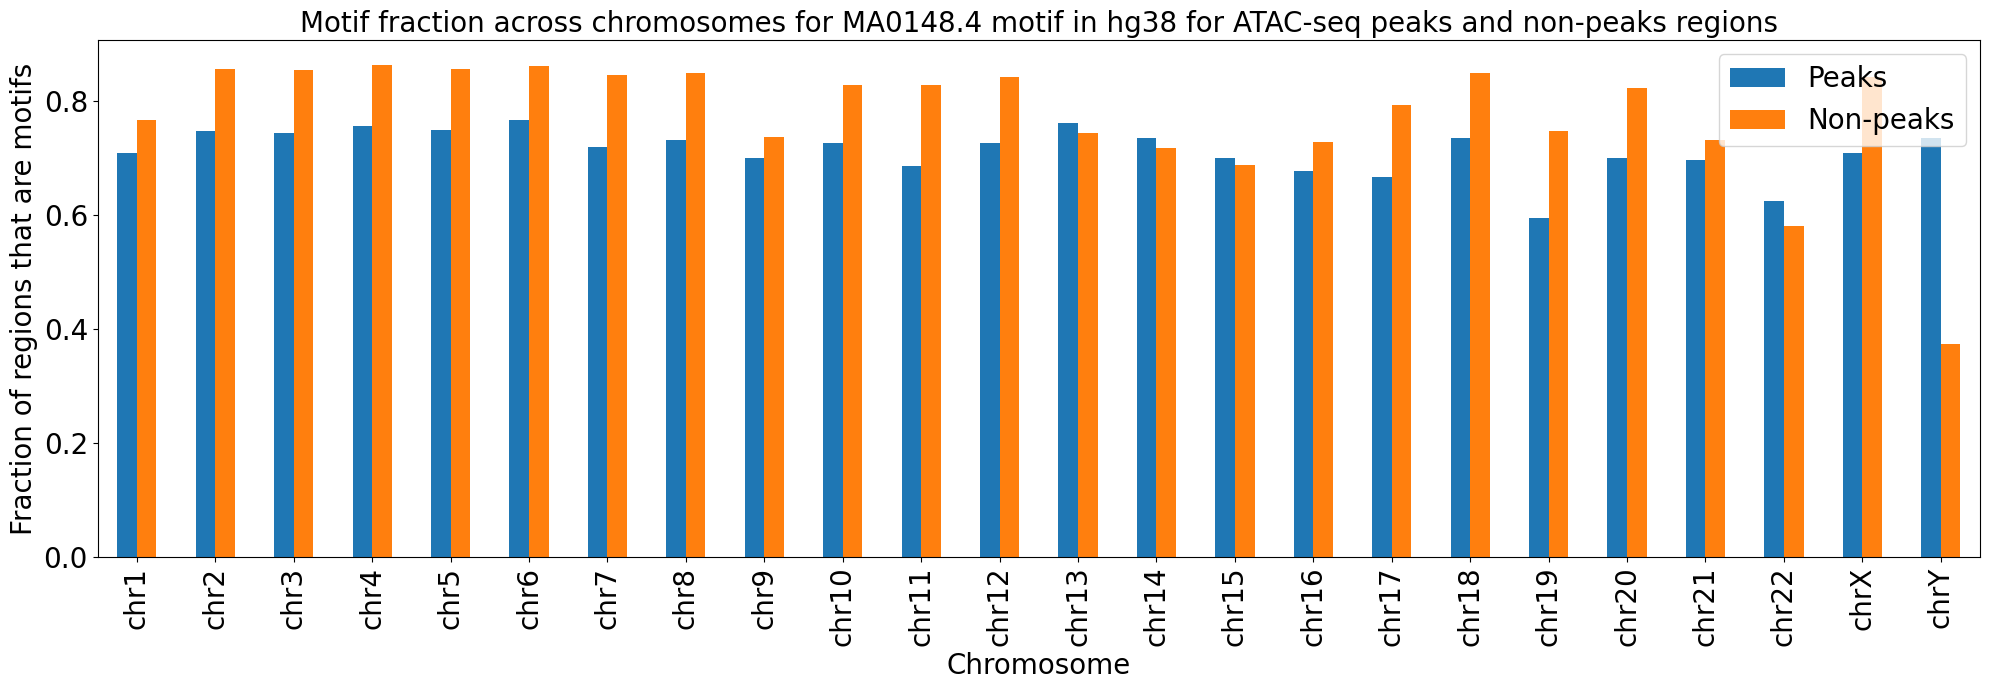

In [35]:
fig, ax = plt.subplots(figsize=(20, 7))

pd.DataFrame(
    {
        "Peaks": pd.Series(frac_peak)[np.argsort(chr_id)],
        "Non-peaks": pd.Series(frac_non_peak)[np.argsort(chr_id)],
    }
).plot.bar(ax=ax)

ax.set_xlabel("Chromosome", fontsize=20)
ax.set_ylabel("Fraction of regions that are motifs", fontsize=20)
ax.set_title(
    f"Motif fraction across chromosomes for {profile} motif in hg38 for ATAC-seq peaks and non-peaks regions",
    fontsize=20,
)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.legend(fontsize=20)
fig.tight_layout()


In [36]:
# test if there is significant difference between the two groups
values_peak = []
values_non_peak = []
for k in frac_peak.keys():
    values_peak.append(frac_peak[k])
    values_non_peak.append(frac_non_peak[k])

# calculate the p-value using a two-sided t-test
from scipy.stats import ttest_ind
t, p = ttest_ind(values_peak, values_non_peak)
print(f"t-statistic: {t}, p-value: {p}")

from scipy.stats import wilcoxon
t, p = wilcoxon(values_peak, values_non_peak)
print(f"t-statistic: {t}, p-value: {p}")

t-statistic: -2.581290907831167, p-value: 0.013096325183291398
t-statistic: 36.0, p-value: 0.0005675554275512695


### Does turning binary into count help with the situation?

In [37]:
# for each chromosome, plot the fraction of the peaks that have a motif, and the fraction that are not peaks but also have a motif

# first, get the number of peaks that have a motif
peak_motif = {i: 0 for i in genome_size.chrom}
non_peak_motif = {i: 0 for i in genome_size.chrom}
peak_size = {i: 0 for i in genome_size.chrom}
non_peak_size = {i: 0 for i in genome_size.chrom}
for i in tqdm(genome_size.itertuples(), total=genome_size.shape[0]):
    motif_cover_pos = np.zeros(i.size, dtype=np.int32)
    motif_cover_neg = np.zeros(i.size, dtype=np.int32)
    peak_cover = np.zeros(i.size, dtype=bool)
    motif_bed_pos_chr = motif_pos_bed.query(f"chrom == '{i.chrom}'")
    motif_bed_neg_chr = motif_neg_bed.query(f"chrom == '{i.chrom}'")
    atac_bed_dedup_chr = atac_bed_dedup.query(f"chrom == '{i.chrom}'")
    for j in motif_bed_pos_chr.itertuples():
        motif_cover_pos[j.chromStart : j.chromEnd] += 1
    for j in motif_bed_neg_chr.itertuples():
        motif_cover_neg[j.chromStart : j.chromEnd] += 1
    for j in atac_bed_dedup_chr.itertuples():
        peak_cover[j.chromStart : j.chromEnd] = True
    motif_cover_either = motif_cover_pos + motif_cover_neg
    peak_motif[i.chrom] = motif_cover_either[peak_cover].sum()
    non_peak_motif[i.chrom] = motif_cover_either[~peak_cover].sum()
    peak_size[i.chrom] = peak_cover.sum()
    non_peak_size[i.chrom] = (~peak_cover).sum()

frac_peak = {}
frac_non_peak = {}
for i in genome_size.itertuples():
    if peak_motif[i.chrom] == 0:
        continue
    frac_peak[i.chrom] = peak_motif[i.chrom] / peak_size[i.chrom]
    frac_non_peak[i.chrom] = non_peak_motif[i.chrom] / non_peak_size[i.chrom]

chr_id = list(
    map(lambda x: int(x[3:]) if x[3:].isdigit() else ord(x[3:]), frac_peak.keys())
)


  0%|          | 0/25 [00:00<?, ?it/s]

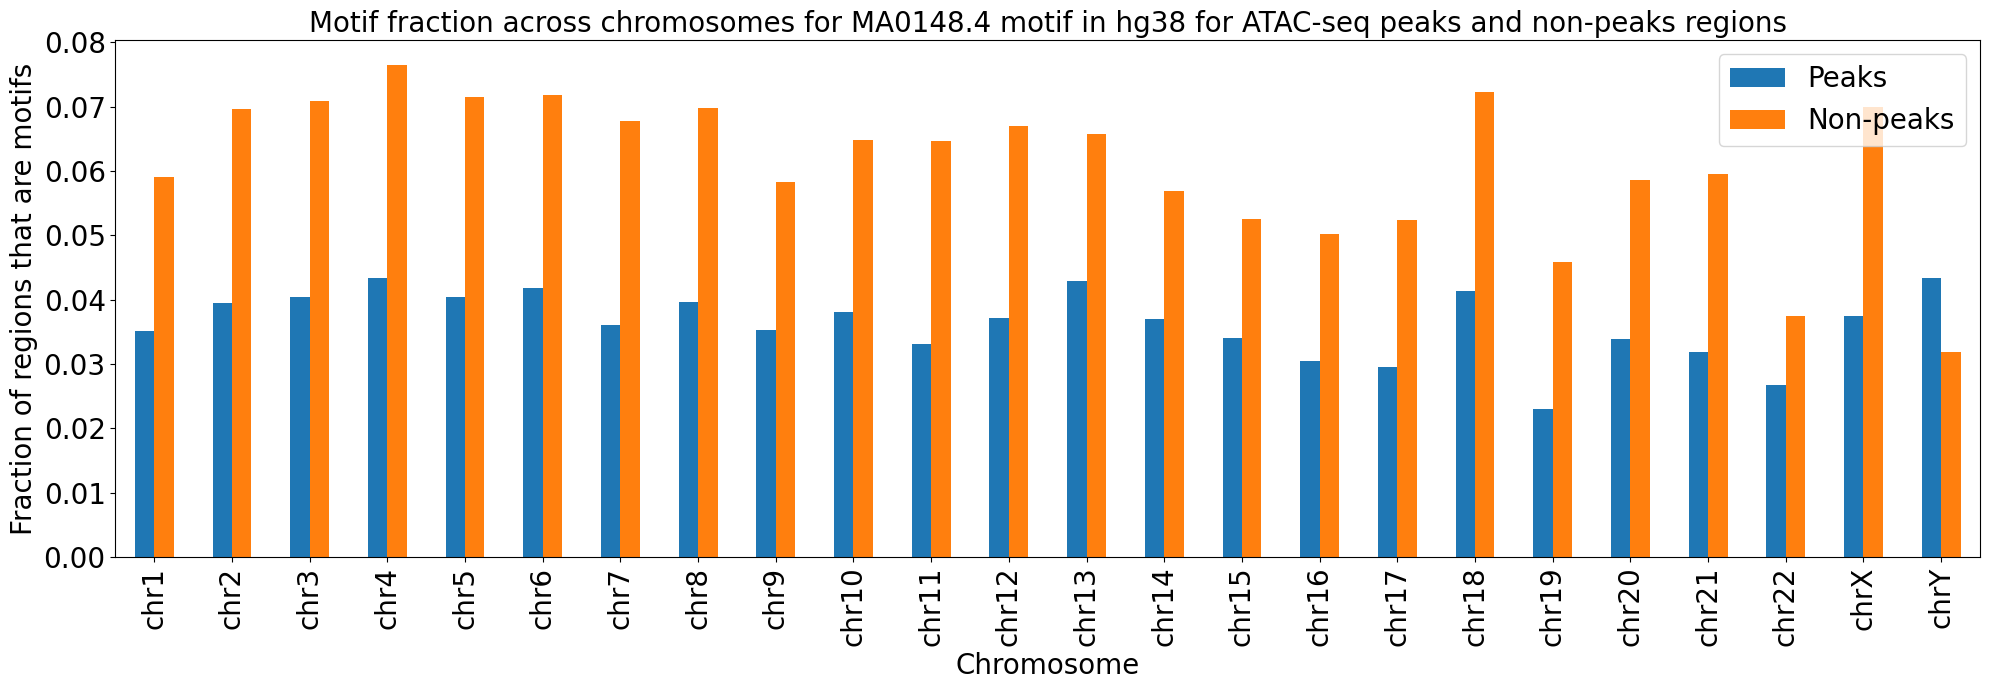

In [38]:
# each chromosome will have 2 bars, one for peaks and one for non peaks
fig, ax = plt.subplots(figsize=(20, 7))

pd.DataFrame(
    {
        "Peaks": pd.Series(frac_peak)[np.argsort(chr_id)],
        "Non-peaks": pd.Series(frac_non_peak)[np.argsort(chr_id)],
    }
).plot.bar(ax=ax)

# set reasonable axis names and title, make axis and tick label font larger
ax.set_xlabel("Chromosome", fontsize=20)
ax.set_ylabel("Fraction of regions that are motifs", fontsize=20)
ax.set_title(
    f"Motif fraction across chromosomes for {profile} motif in hg38 for ATAC-seq peaks and non-peaks regions",
    fontsize=20,
)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.legend(fontsize=20)
fig.tight_layout()


In [39]:
# first, get the number of peaks that have a motif
peak_motif = {i: 0 for i in genome_size.chrom}
non_peak_motif = {i: 0 for i in genome_size.chrom}
peak_num = {i: 0 for i in genome_size.chrom}
non_peak_num = {i: 0 for i in genome_size.chrom}
for i in tqdm(genome_size.itertuples(), total=genome_size.shape[0]):
    motif_cover_pos = np.zeros(i.size, dtype=np.int32)
    motif_cover_neg = np.zeros(i.size, dtype=np.int32)
    motif_bed_pos_chr = motif_pos_bed.query(f"chrom == '{i.chrom}'")
    motif_bed_neg_chr = motif_neg_bed.query(f"chrom == '{i.chrom}'")
    atac_bed_dedup_chr = atac_bed_dedup.query(f"chrom == '{i.chrom}'")
    atac_bed_bg_chr = sample_background_regions(atac_bed_dedup_chr, i.size, factor=2)
    for j in motif_bed_pos_chr.itertuples():
        motif_cover_pos[j.chromStart : j.chromEnd] += 1
    for j in motif_bed_neg_chr.itertuples():
        motif_cover_neg[j.chromStart : j.chromEnd] += 1

    motif_cover_either = motif_cover_pos + motif_cover_neg

    peak_num[i.chrom] = atac_bed_dedup_chr.shape[0]
    non_peak_num[i.chrom] = atac_bed_bg_chr.shape[0]

    if atac_bed_dedup_chr.shape[0] == 0:
        continue

    peak_has_motif = atac_bed_dedup_chr.apply(
        lambda x: motif_cover_either[
            x.chromStart + motif_length : x.chromEnd - motif_length
        ].sum() / motif_length,
        axis=1,
    )
    peak_motif[i.chrom] = peak_has_motif.sum()

    non_peak_has_motif = atac_bed_bg_chr.apply(
        lambda x: motif_cover_either[
            x.chromStart + motif_length : x.chromEnd - motif_length
        ].sum() / motif_length,
        axis=1,
    )
    non_peak_motif[i.chrom] = non_peak_has_motif.sum()


  0%|          | 0/25 [00:00<?, ?it/s]

In [40]:
frac_peak = {}
frac_non_peak = {}
for i in genome_size.itertuples():
    if peak_motif[i.chrom] == 0:
        continue
    frac_peak[i.chrom] = peak_motif[i.chrom] / peak_num[i.chrom]
    frac_non_peak[i.chrom] = non_peak_motif[i.chrom] / non_peak_num[i.chrom]

chr_id = list(
    map(lambda x: int(x[3:]) if x[3:].isdigit() else ord(x[3:]), frac_peak.keys())
)


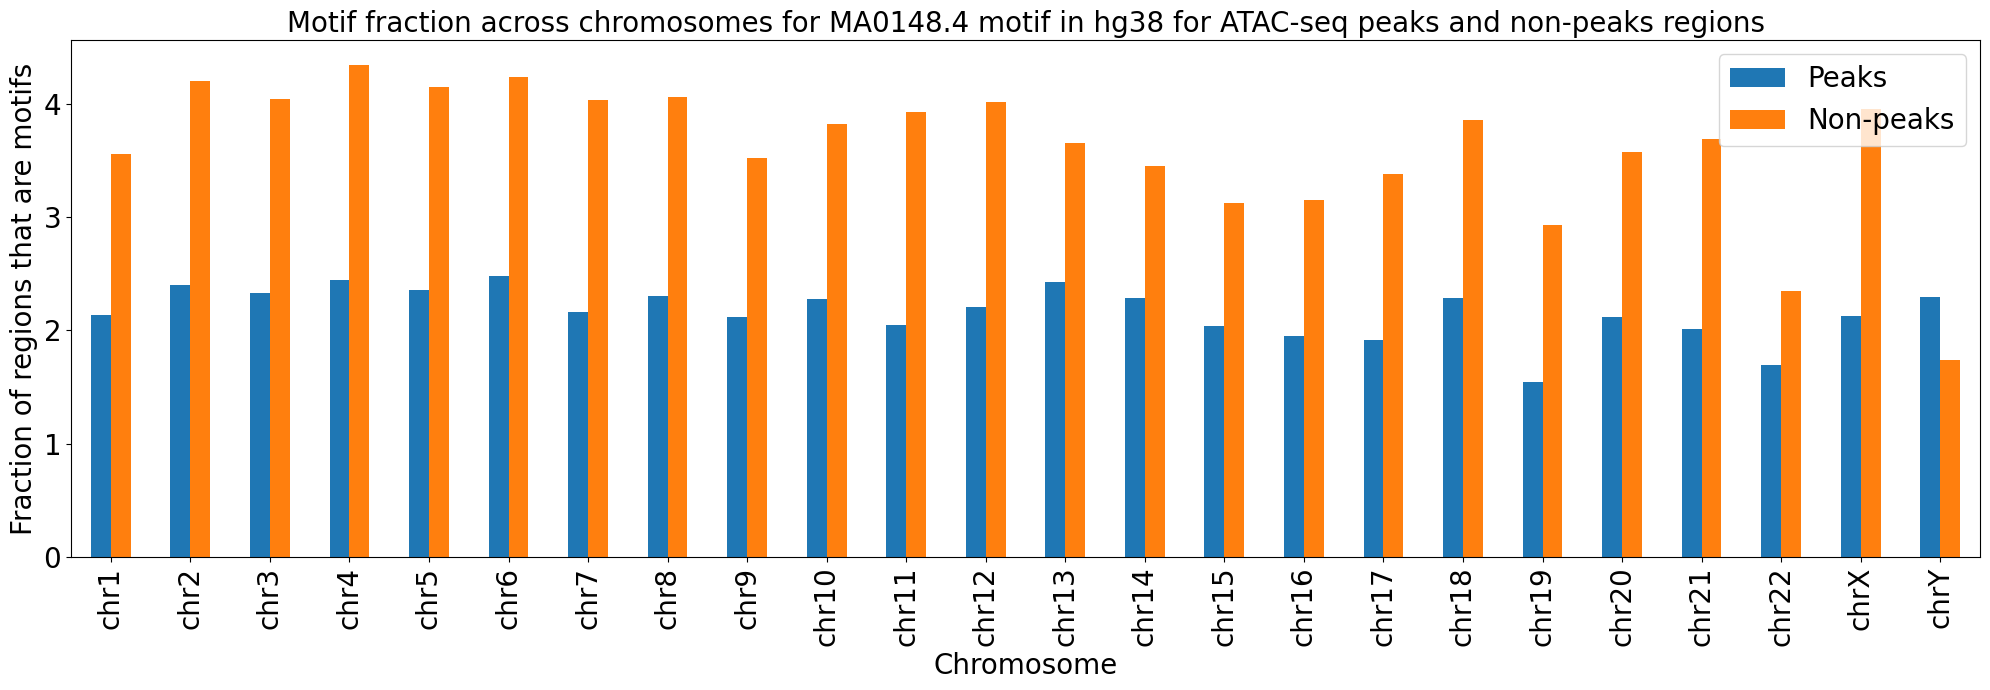

In [41]:
fig, ax = plt.subplots(figsize=(20, 7))

pd.DataFrame(
    {
        "Peaks": pd.Series(frac_peak)[np.argsort(chr_id)],
        "Non-peaks": pd.Series(frac_non_peak)[np.argsort(chr_id)],
    }
).plot.bar(ax=ax)

ax.set_xlabel("Chromosome", fontsize=20)
ax.set_ylabel("Fraction of regions that are motifs", fontsize=20)
ax.set_title(
    f"Motif fraction across chromosomes for {profile} motif in hg38 for ATAC-seq peaks and non-peaks regions",
    fontsize=20,
)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.legend(fontsize=20)
fig.tight_layout()


In [42]:
# first, get the number of peaks that have a motif
peak_motif = {i: 0 for i in genome_size.chrom}
non_peak_motif = {i: 0 for i in genome_size.chrom}
peak_num = {i: 0 for i in genome_size.chrom}
non_peak_num = {i: 0 for i in genome_size.chrom}
for i in tqdm(genome_size.itertuples(), total=genome_size.shape[0]):
    motif_cover_pos = np.zeros(i.size, dtype=np.int32)
    motif_cover_neg = np.zeros(i.size, dtype=np.int32)
    motif_bed_pos_chr = motif_pos_bed.query(f"chrom == '{i.chrom}'")
    motif_bed_neg_chr = motif_neg_bed.query(f"chrom == '{i.chrom}'")
    atac_bed_dedup_chr = atac_bed_dedup.query(f"chrom == '{i.chrom}'")
    atac_bed_bg_chr = sample_background_regions(atac_bed_dedup_chr, i.size, factor=2)
    for j in motif_bed_pos_chr.itertuples():
        motif_cover_pos[j.chromStart] += 1
    for j in motif_bed_neg_chr.itertuples():
        motif_cover_neg[j.chromStart] += 1

    motif_cover_either = motif_cover_pos + motif_cover_neg

    peak_num[i.chrom] = atac_bed_dedup_chr.shape[0]
    non_peak_num[i.chrom] = atac_bed_bg_chr.shape[0]

    if atac_bed_dedup_chr.shape[0] == 0:
        continue

    peak_has_motif = atac_bed_dedup_chr.apply(
        lambda x: motif_cover_either[x.chromStart : x.chromEnd - motif_length].sum(),
        axis=1,
    )
    peak_motif[i.chrom] = peak_has_motif.sum()

    non_peak_has_motif = atac_bed_bg_chr.apply(
        lambda x: motif_cover_either[x.chromStart : x.chromEnd - motif_length].sum(),
        axis=1,
    )
    non_peak_motif[i.chrom] = non_peak_has_motif.sum()

frac_peak = {}
frac_non_peak = {}
for i in genome_size.itertuples():
    if peak_motif[i.chrom] == 0:
        continue
    frac_peak[i.chrom] = peak_motif[i.chrom] / peak_num[i.chrom]
    frac_non_peak[i.chrom] = non_peak_motif[i.chrom] / non_peak_num[i.chrom]

chr_id = list(
    map(lambda x: int(x[3:]) if x[3:].isdigit() else ord(x[3:]), frac_peak.keys())
)


  0%|          | 0/25 [00:00<?, ?it/s]

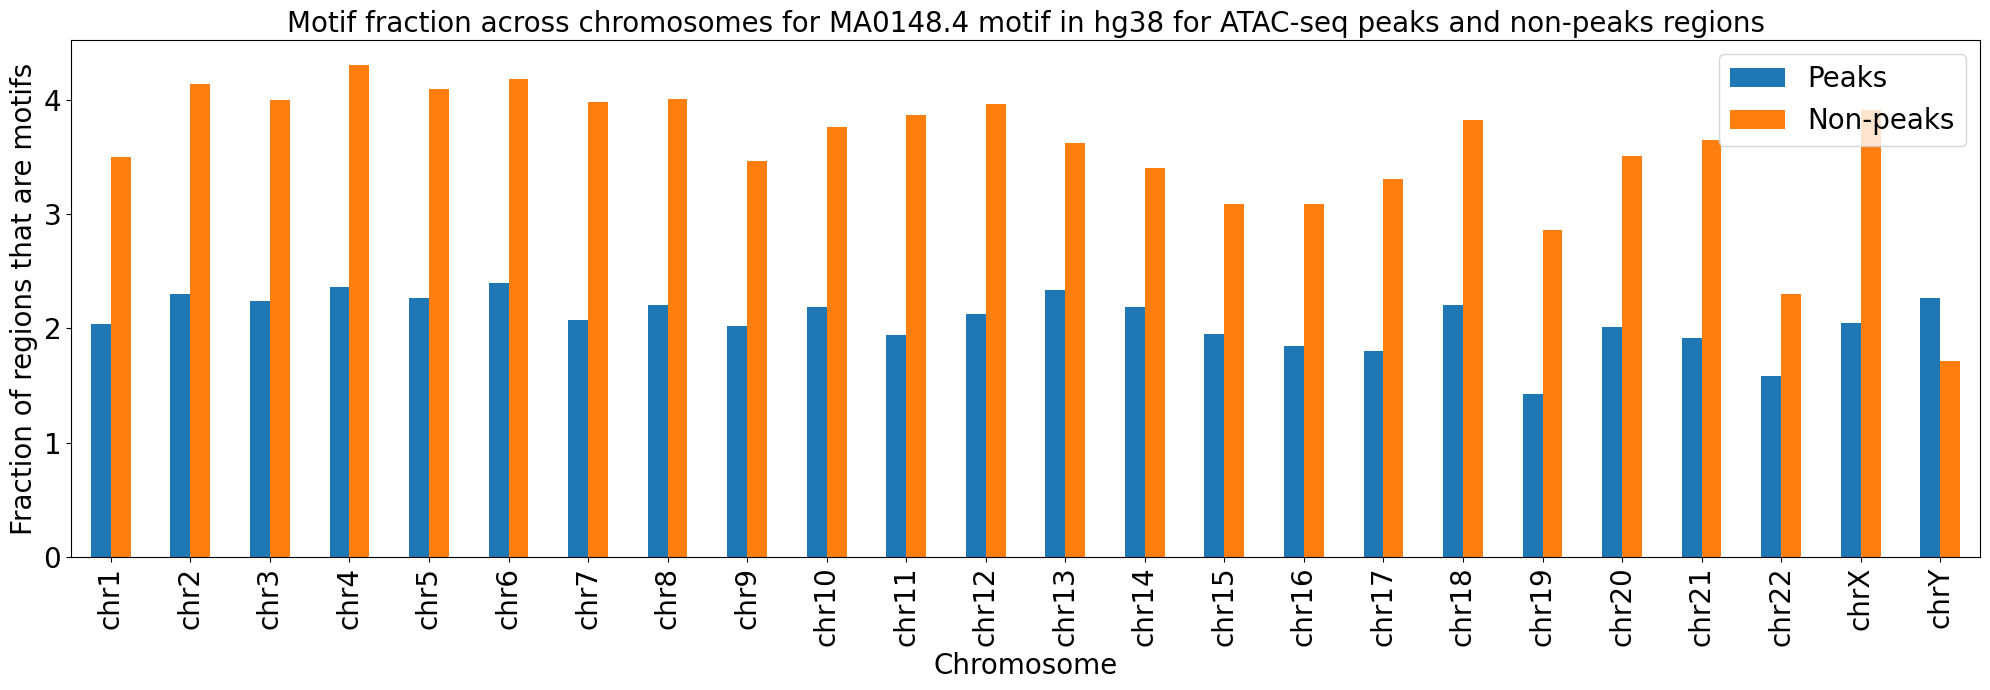

In [43]:
fig, ax = plt.subplots(figsize=(20, 7))

pd.DataFrame(
    {
        "Peaks": pd.Series(frac_peak)[np.argsort(chr_id)],
        "Non-peaks": pd.Series(frac_non_peak)[np.argsort(chr_id)],
    }
).plot.bar(ax=ax)

ax.set_xlabel("Chromosome", fontsize=20)
ax.set_ylabel("Fraction of regions that are motifs", fontsize=20)
ax.set_title(
    f"Motif fraction across chromosomes for {profile} motif in hg38 for ATAC-seq peaks and non-peaks regions",
    fontsize=20,
)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.legend(fontsize=20)
fig.tight_layout()


### Do the same thing, but for ChIP-seq peak.

#### Fig 1

In [44]:
# for each chromosome, plot the fraction of the peaks that have a motif, and the fraction that are not peaks but also have a motif

# first, get the number of peaks that have a motif
peak_motif = {i: 0 for i in genome_size.chrom}
non_peak_motif = {i: 0 for i in genome_size.chrom}
peak_size = {i: 0 for i in genome_size.chrom}
non_peak_size = {i: 0 for i in genome_size.chrom}
for i in tqdm(genome_size.itertuples(), total=genome_size.shape[0]):
    motif_cover_pos = np.zeros(i.size, dtype=bool)
    motif_cover_neg = np.zeros(i.size, dtype=bool)
    peak_cover = np.zeros(i.size, dtype=bool)
    motif_bed_pos_chr = motif_pos_bed.query(f"chrom == '{i.chrom}'")
    motif_bed_neg_chr = motif_neg_bed.query(f"chrom == '{i.chrom}'")
    tf_bed_dedup_chr = tf_bed_dedup.query(f"chrom == '{i.chrom}'")
    for j in motif_bed_pos_chr.itertuples():
        motif_cover_pos[j.chromStart : j.chromEnd] = True
    for j in motif_bed_neg_chr.itertuples():
        motif_cover_neg[j.chromStart : j.chromEnd] = True
    for j in tf_bed_dedup_chr.itertuples():
        peak_cover[j.chromStart : j.chromEnd] = True
    motif_cover_either = motif_cover_pos | motif_cover_neg
    peak_motif[i.chrom] = (peak_cover & motif_cover_either).sum()
    non_peak_motif[i.chrom] = (~peak_cover & motif_cover_either).sum()
    peak_size[i.chrom] = peak_cover.sum()
    non_peak_size[i.chrom] = (~peak_cover).sum()

frac_peak = {}
frac_non_peak = {}
for i in genome_size.itertuples():
    if peak_motif[i.chrom] == 0:
        continue
    frac_peak[i.chrom] = peak_motif[i.chrom] / peak_size[i.chrom]
    frac_non_peak[i.chrom] = non_peak_motif[i.chrom] / non_peak_size[i.chrom]
    
chr_id = list(
    map(lambda x: int(x[3:]) if x[3:].isdigit() else ord(x[3:]), frac_peak.keys())
)


  0%|          | 0/25 [00:00<?, ?it/s]

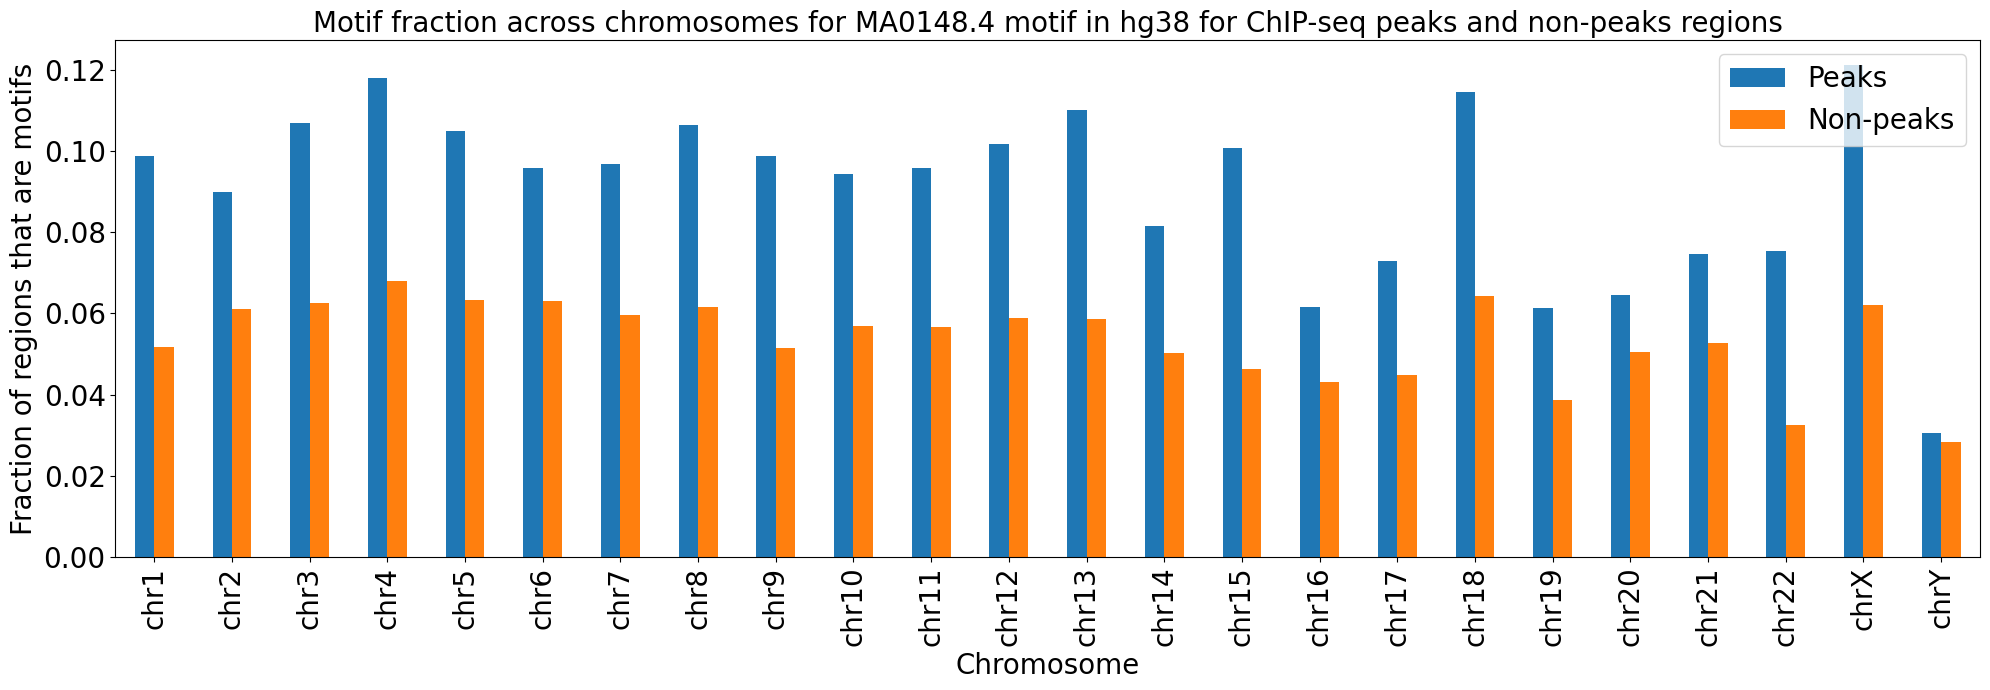

In [45]:
# each chromosome will have 2 bars, one for peaks and one for non peaks
fig, ax = plt.subplots(figsize=(20, 7))

pd.DataFrame(
    {
        "Peaks": pd.Series(frac_peak)[np.argsort(chr_id)],
        "Non-peaks": pd.Series(frac_non_peak)[np.argsort(chr_id)],
    }
).plot.bar(ax=ax)

# set reasonable axis names and title, make axis and tick label font larger
ax.set_xlabel("Chromosome", fontsize=20)
ax.set_ylabel("Fraction of regions that are motifs", fontsize=20)
ax.set_title(
    f"Motif fraction across chromosomes for {profile} motif in hg38 for ChIP-seq peaks and non-peaks regions",
    fontsize=20,
)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.legend(fontsize=20)
fig.tight_layout()


#### Fig 2

In [46]:
# for each chromosome, plot the fraction of the peaks that have a motif, and the fraction that are not peaks but also have a motif
# Methodology: If a motif is fully contained in a peak, we count this peak as having motif.
# Thus, we calculate the fraction of peaks that have a motif.
# As background, we randomly sample the same number of regions as peaks (take length distribution into account), and calculate the fraction of these regions that have a motif.


def sample_background_regions(
    atac_bed_chr: pd.DataFrame, chr_length: int, factor: int = 1, seed: int = 42
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    starts = []
    ends = []
    for _ in range(factor):
        start = rng.integers(0, chr_length, size=atac_bed_chr.shape[0])
        starts.append(start)
        end = start + (atac_bed_chr.chromEnd - atac_bed_chr.chromStart)
        ends.append(end)
    starts = np.concatenate(starts)
    ends = np.concatenate(ends)
    return pd.DataFrame(dict(chromStart=starts, chromEnd=ends))


In [47]:
# first, get the number of peaks that have a motif
peak_motif = {i: 0 for i in genome_size.chrom}
non_peak_motif = {i: 0 for i in genome_size.chrom}
peak_num = {i: 0 for i in genome_size.chrom}
non_peak_num = {i: 0 for i in genome_size.chrom}
for i in tqdm(genome_size.itertuples(), total=genome_size.shape[0]):
    motif_cover_pos = np.zeros(i.size, dtype=bool)
    motif_cover_neg = np.zeros(i.size, dtype=bool)
    motif_bed_pos_chr = motif_pos_bed.query(f"chrom == '{i.chrom}'")
    motif_bed_neg_chr = motif_neg_bed.query(f"chrom == '{i.chrom}'")
    tf_bed_dedup_chr = tf_bed_dedup.query(f"chrom == '{i.chrom}'")
    tf_bed_bg_chr = sample_background_regions(tf_bed_dedup_chr, i.size, factor=2)
    for j in motif_bed_pos_chr.itertuples():
        motif_cover_pos[j.chromStart : j.chromEnd] = True
    for j in motif_bed_neg_chr.itertuples():
        motif_cover_neg[j.chromStart : j.chromEnd] = True

    motif_cover_either = motif_cover_pos | motif_cover_neg

    peak_num[i.chrom] = tf_bed_dedup_chr.shape[0]
    non_peak_num[i.chrom] = tf_bed_bg_chr.shape[0]

    if tf_bed_dedup_chr.shape[0] == 0:
        continue

    peak_has_motif = tf_bed_dedup_chr.apply(
        lambda x: motif_cover_either[
            x.chromStart + motif_length : x.chromEnd - motif_length
        ].any(),
        axis=1,
    )
    peak_motif[i.chrom] = peak_has_motif.sum()

    non_peak_has_motif = tf_bed_bg_chr.apply(
        lambda x: motif_cover_either[
            x.chromStart + motif_length : x.chromEnd - motif_length
        ].any(),
        axis=1,
    )
    non_peak_motif[i.chrom] = non_peak_has_motif.sum()


  0%|          | 0/25 [00:00<?, ?it/s]

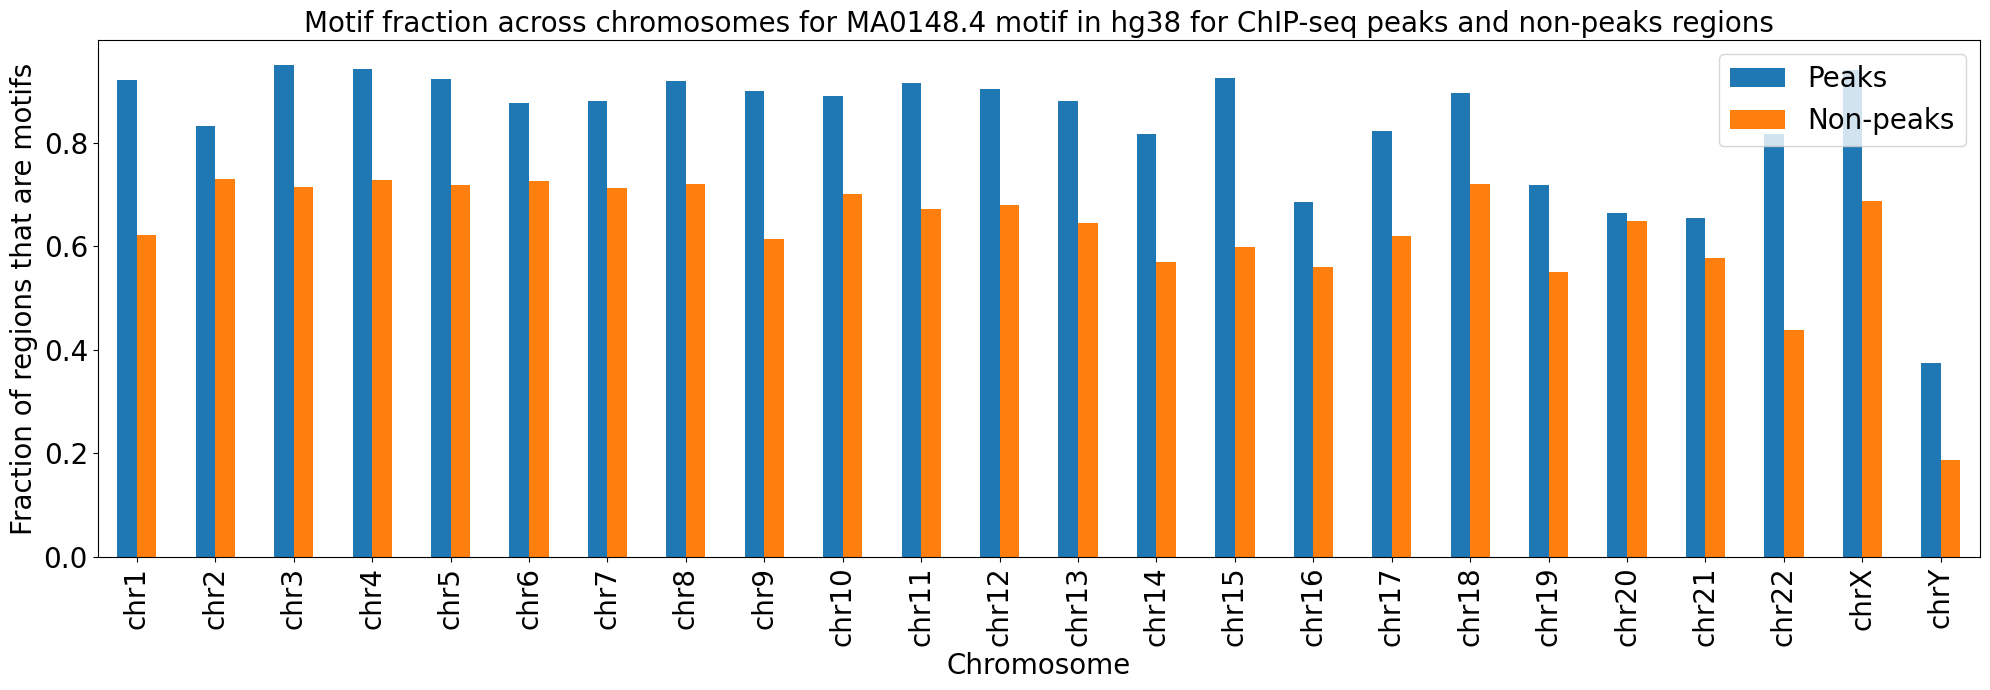

In [48]:
frac_peak = {}
frac_non_peak = {}
for i in genome_size.itertuples():
    if peak_motif[i.chrom] == 0:
        continue
    frac_peak[i.chrom] = peak_motif[i.chrom] / peak_num[i.chrom]
    frac_non_peak[i.chrom] = non_peak_motif[i.chrom] / non_peak_num[i.chrom]

chr_id = list(
    map(lambda x: int(x[3:]) if x[3:].isdigit() else ord(x[3:]), frac_peak.keys())
)

fig, ax = plt.subplots(figsize=(20, 7))

pd.DataFrame(
    {
        "Peaks": pd.Series(frac_peak)[np.argsort(chr_id)],
        "Non-peaks": pd.Series(frac_non_peak)[np.argsort(chr_id)],
    }
).plot.bar(ax=ax)

ax.set_xlabel("Chromosome", fontsize=20)
ax.set_ylabel("Fraction of regions that are motifs", fontsize=20)
ax.set_title(
    f"Motif fraction across chromosomes for {profile} motif in hg38 for ChIP-seq peaks and non-peaks regions",
    fontsize=20,
)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.legend(fontsize=20)
fig.tight_layout()


In [49]:
# test if there is significant difference between the two groups
# values_peak = []
# values_non_peak = []
# for k in frac_peak.keys():
#     values_peak.append(frac_peak[k])
#     values_non_peak.append(frac_non_peak[k])

# # calculate the p-value using a two-sided t-test
# from scipy.stats import ttest_ind
# t, p = ttest_ind(values_peak, values_non_peak)
# print(f"t-statistic: {t}, p-value: {p}")

# from scipy.stats import wilcoxon
# t, p = wilcoxon(values_peak, values_non_peak)
# print(f"t-statistic: {t}, p-value: {p}")

#### Fig 3

In [50]:
# for each chromosome, plot the fraction of the peaks that have a motif, and the fraction that are not peaks but also have a motif

# first, get the number of peaks that have a motif
peak_motif = {i: 0 for i in genome_size.chrom}
non_peak_motif = {i: 0 for i in genome_size.chrom}
peak_size = {i: 0 for i in genome_size.chrom}
non_peak_size = {i: 0 for i in genome_size.chrom}
for i in tqdm(genome_size.itertuples(), total=genome_size.shape[0]):
    motif_cover_pos = np.zeros(i.size, dtype=np.int32)
    motif_cover_neg = np.zeros(i.size, dtype=np.int32)
    peak_cover = np.zeros(i.size, dtype=bool)
    motif_bed_pos_chr = motif_pos_bed.query(f"chrom == '{i.chrom}'")
    motif_bed_neg_chr = motif_neg_bed.query(f"chrom == '{i.chrom}'")
    tf_bed_dedup_chr = tf_bed_dedup.query(f"chrom == '{i.chrom}'")
    for j in motif_bed_pos_chr.itertuples():
        motif_cover_pos[j.chromStart : j.chromEnd] += 1
    for j in motif_bed_neg_chr.itertuples():
        motif_cover_neg[j.chromStart : j.chromEnd] += 1
    for j in tf_bed_dedup_chr.itertuples():
        peak_cover[j.chromStart : j.chromEnd] = True
    motif_cover_either = motif_cover_pos + motif_cover_neg
    peak_motif[i.chrom] = motif_cover_either[peak_cover].sum()
    non_peak_motif[i.chrom] = motif_cover_either[~peak_cover].sum()
    peak_size[i.chrom] = peak_cover.sum()
    non_peak_size[i.chrom] = (~peak_cover).sum()

frac_peak = {}
frac_non_peak = {}
for i in genome_size.itertuples():
    if peak_motif[i.chrom] == 0:
        continue
    frac_peak[i.chrom] = peak_motif[i.chrom] / peak_size[i.chrom]
    frac_non_peak[i.chrom] = non_peak_motif[i.chrom] / non_peak_size[i.chrom]

chr_id = list(
    map(lambda x: int(x[3:]) if x[3:].isdigit() else ord(x[3:]), frac_peak.keys())
)


  0%|          | 0/25 [00:00<?, ?it/s]

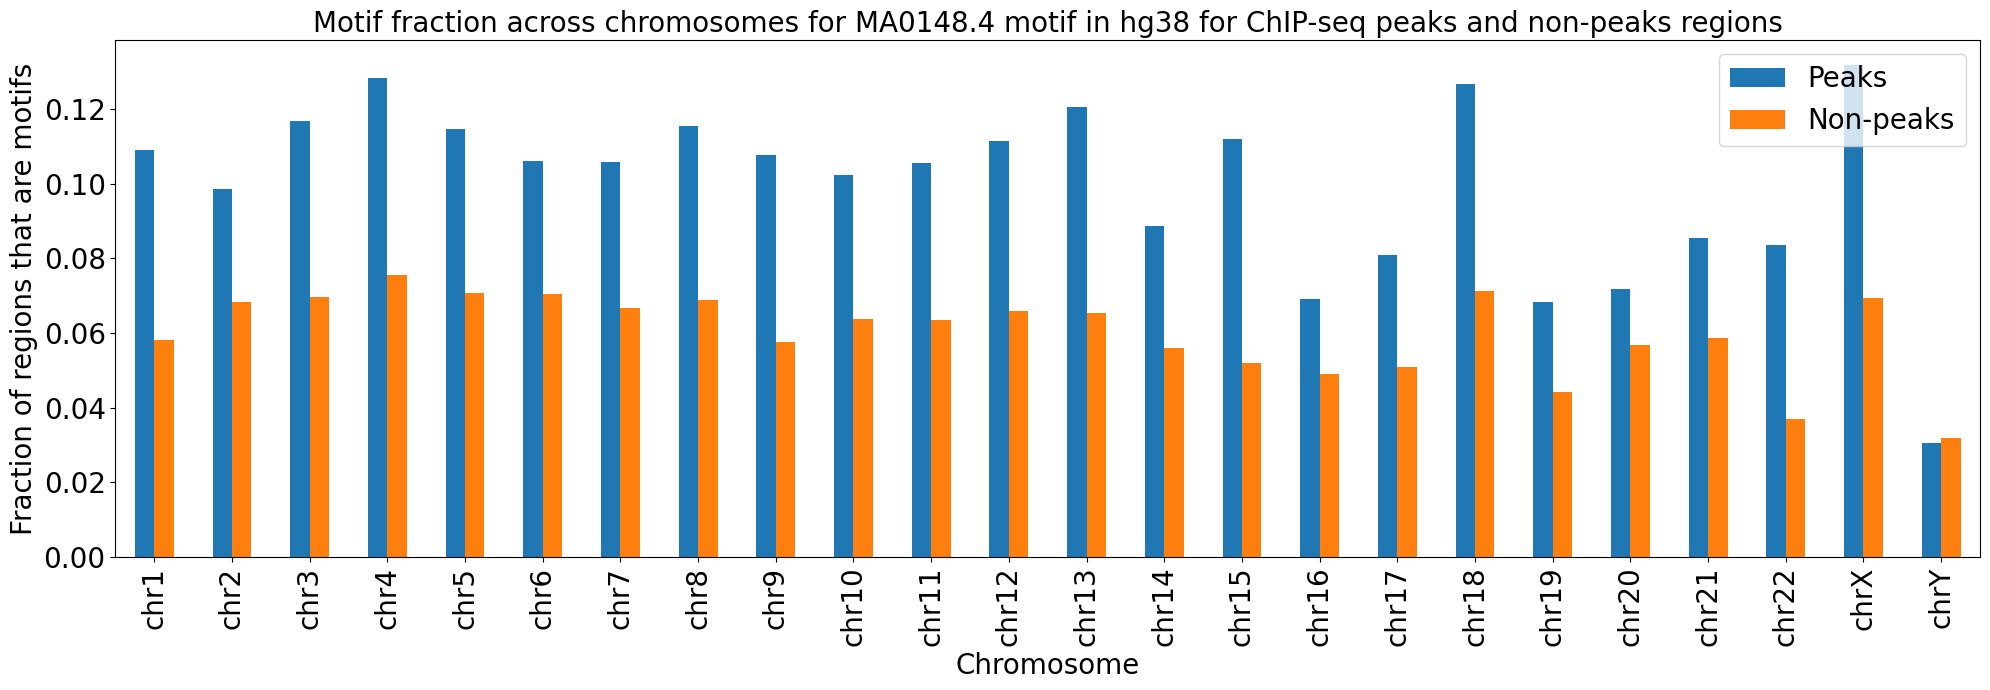

In [51]:
# each chromosome will have 2 bars, one for peaks and one for non peaks
fig, ax = plt.subplots(figsize=(20, 7))

pd.DataFrame(
    {
        "Peaks": pd.Series(frac_peak)[np.argsort(chr_id)],
        "Non-peaks": pd.Series(frac_non_peak)[np.argsort(chr_id)],
    }
).plot.bar(ax=ax)

# set reasonable axis names and title, make axis and tick label font larger
ax.set_xlabel("Chromosome", fontsize=20)
ax.set_ylabel("Fraction of regions that are motifs", fontsize=20)
ax.set_title(
    f"Motif fraction across chromosomes for {profile} motif in hg38 for ChIP-seq peaks and non-peaks regions",
    fontsize=20,
)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.legend(fontsize=20)
fig.tight_layout()


#### Fig 4

In [52]:
# first, get the number of peaks that have a motif
peak_motif = {i: 0 for i in genome_size.chrom}
non_peak_motif = {i: 0 for i in genome_size.chrom}
peak_num = {i: 0 for i in genome_size.chrom}
non_peak_num = {i: 0 for i in genome_size.chrom}
for i in tqdm(genome_size.itertuples(), total=genome_size.shape[0]):
    motif_cover_pos = np.zeros(i.size, dtype=np.int32)
    motif_cover_neg = np.zeros(i.size, dtype=np.int32)
    motif_bed_pos_chr = motif_pos_bed.query(f"chrom == '{i.chrom}'")
    motif_bed_neg_chr = motif_neg_bed.query(f"chrom == '{i.chrom}'")
    tf_bed_dedup_chr = tf_bed_dedup.query(f"chrom == '{i.chrom}'")
    tf_bed_bg_chr = sample_background_regions(tf_bed_dedup_chr, i.size, factor=2)
    for j in motif_bed_pos_chr.itertuples():
        motif_cover_pos[j.chromStart : j.chromEnd] += 1
    for j in motif_bed_neg_chr.itertuples():
        motif_cover_neg[j.chromStart : j.chromEnd] += 1

    motif_cover_either = motif_cover_pos + motif_cover_neg

    peak_num[i.chrom] = tf_bed_dedup_chr.shape[0]
    non_peak_num[i.chrom] = tf_bed_bg_chr.shape[0]

    if tf_bed_dedup_chr.shape[0] == 0:
        continue

    peak_has_motif = tf_bed_dedup_chr.apply(
        lambda x: motif_cover_either[
            x.chromStart + motif_length : x.chromEnd - motif_length
        ].sum() / motif_length,
        axis=1,
    )
    peak_motif[i.chrom] = peak_has_motif.sum()

    non_peak_has_motif = tf_bed_bg_chr.apply(
        lambda x: motif_cover_either[
            x.chromStart + motif_length : x.chromEnd - motif_length
        ].sum() / motif_length,
        axis=1,
    )
    non_peak_motif[i.chrom] = non_peak_has_motif.sum()


  0%|          | 0/25 [00:00<?, ?it/s]

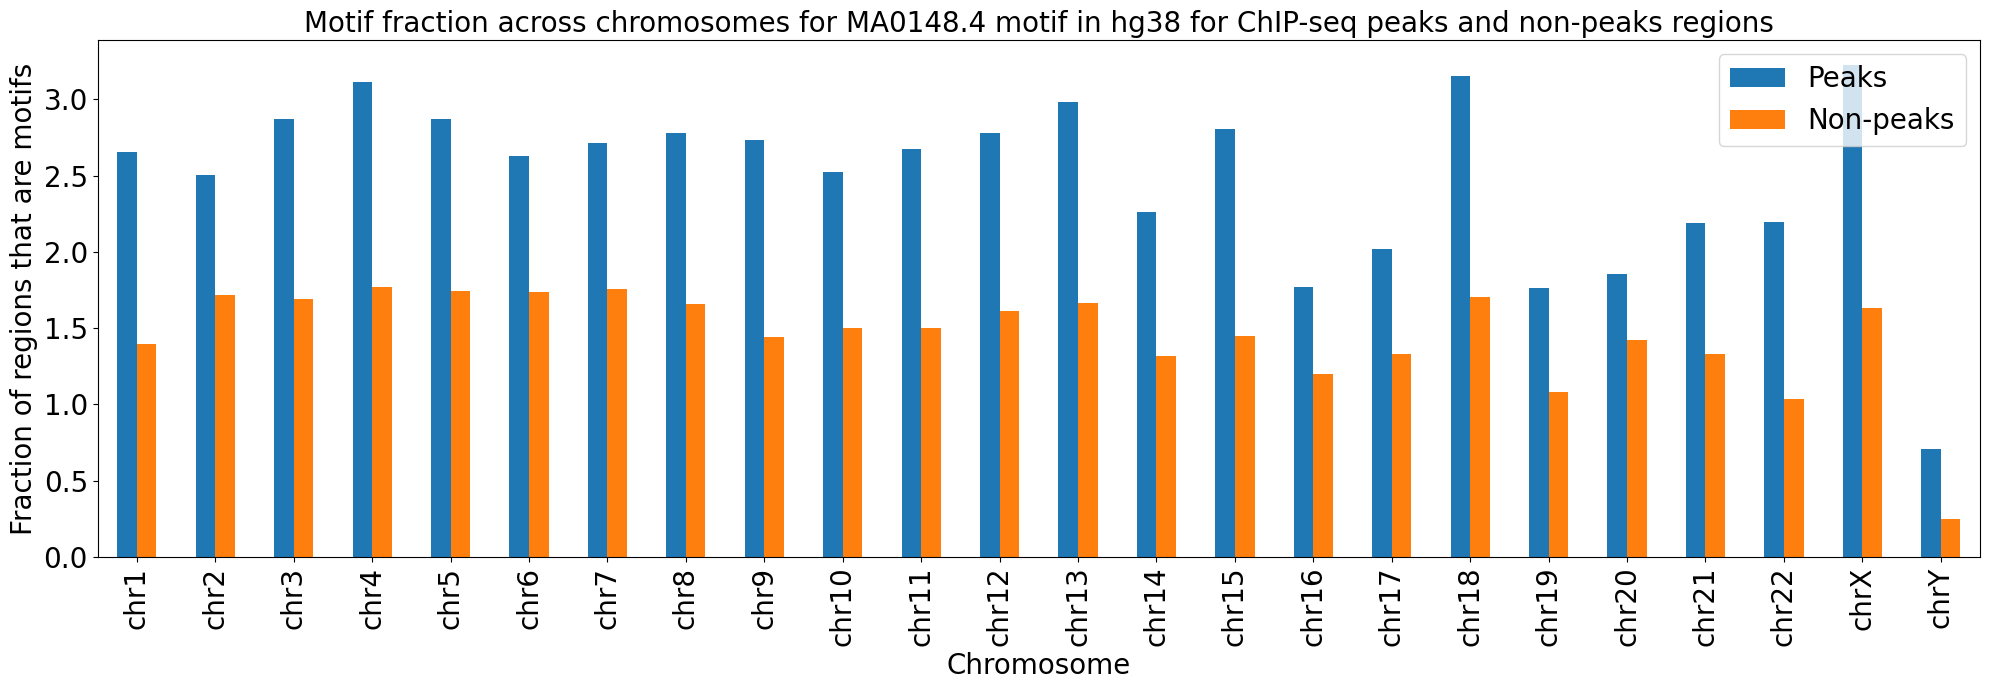

In [53]:
frac_peak = {}
frac_non_peak = {}
for i in genome_size.itertuples():
    if peak_motif[i.chrom] == 0:
        continue
    frac_peak[i.chrom] = peak_motif[i.chrom] / peak_num[i.chrom]
    frac_non_peak[i.chrom] = non_peak_motif[i.chrom] / non_peak_num[i.chrom]

chr_id = list(
    map(lambda x: int(x[3:]) if x[3:].isdigit() else ord(x[3:]), frac_peak.keys())
)


fig, ax = plt.subplots(figsize=(20, 7))

pd.DataFrame(
    {
        "Peaks": pd.Series(frac_peak)[np.argsort(chr_id)],
        "Non-peaks": pd.Series(frac_non_peak)[np.argsort(chr_id)],
    }
).plot.bar(ax=ax)

ax.set_xlabel("Chromosome", fontsize=20)
ax.set_ylabel("Fraction of regions that are motifs", fontsize=20)
ax.set_title(
    f"Motif fraction across chromosomes for {profile} motif in hg38 for ChIP-seq peaks and non-peaks regions",
    fontsize=20,
)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.legend(fontsize=20)
fig.tight_layout()



#### Fig 5

In [54]:
# first, get the number of peaks that have a motif
peak_motif = {i: 0 for i in genome_size.chrom}
non_peak_motif = {i: 0 for i in genome_size.chrom}
peak_num = {i: 0 for i in genome_size.chrom}
non_peak_num = {i: 0 for i in genome_size.chrom}
for i in tqdm(genome_size.itertuples(), total=genome_size.shape[0]):
    motif_cover_pos = np.zeros(i.size, dtype=np.int32)
    motif_cover_neg = np.zeros(i.size, dtype=np.int32)
    motif_bed_pos_chr = motif_pos_bed.query(f"chrom == '{i.chrom}'")
    motif_bed_neg_chr = motif_neg_bed.query(f"chrom == '{i.chrom}'")
    tf_bed_dedup_chr = tf_bed_dedup.query(f"chrom == '{i.chrom}'")
    tf_bed_bg_chr = sample_background_regions(tf_bed_dedup_chr, i.size, factor=2)
    for j in motif_bed_pos_chr.itertuples():
        motif_cover_pos[j.chromStart] += 1
    for j in motif_bed_neg_chr.itertuples():
        motif_cover_neg[j.chromStart] += 1

    motif_cover_either = motif_cover_pos + motif_cover_neg

    peak_num[i.chrom] = tf_bed_dedup_chr.shape[0]
    non_peak_num[i.chrom] = tf_bed_bg_chr.shape[0]

    if tf_bed_dedup_chr.shape[0] == 0:
        continue

    peak_has_motif = tf_bed_dedup_chr.apply(
        lambda x: motif_cover_either[x.chromStart : x.chromEnd - motif_length].sum(),
        axis=1,
    )
    peak_motif[i.chrom] = peak_has_motif.sum()

    non_peak_has_motif = tf_bed_bg_chr.apply(
        lambda x: motif_cover_either[x.chromStart : x.chromEnd - motif_length].sum(),
        axis=1,
    )
    non_peak_motif[i.chrom] = non_peak_has_motif.sum()

frac_peak = {}
frac_non_peak = {}
for i in genome_size.itertuples():
    if peak_motif[i.chrom] == 0:
        continue
    frac_peak[i.chrom] = peak_motif[i.chrom] / peak_num[i.chrom]
    frac_non_peak[i.chrom] = non_peak_motif[i.chrom] / non_peak_num[i.chrom]

chr_id = list(
    map(lambda x: int(x[3:]) if x[3:].isdigit() else ord(x[3:]), frac_peak.keys())
)


  0%|          | 0/25 [00:00<?, ?it/s]

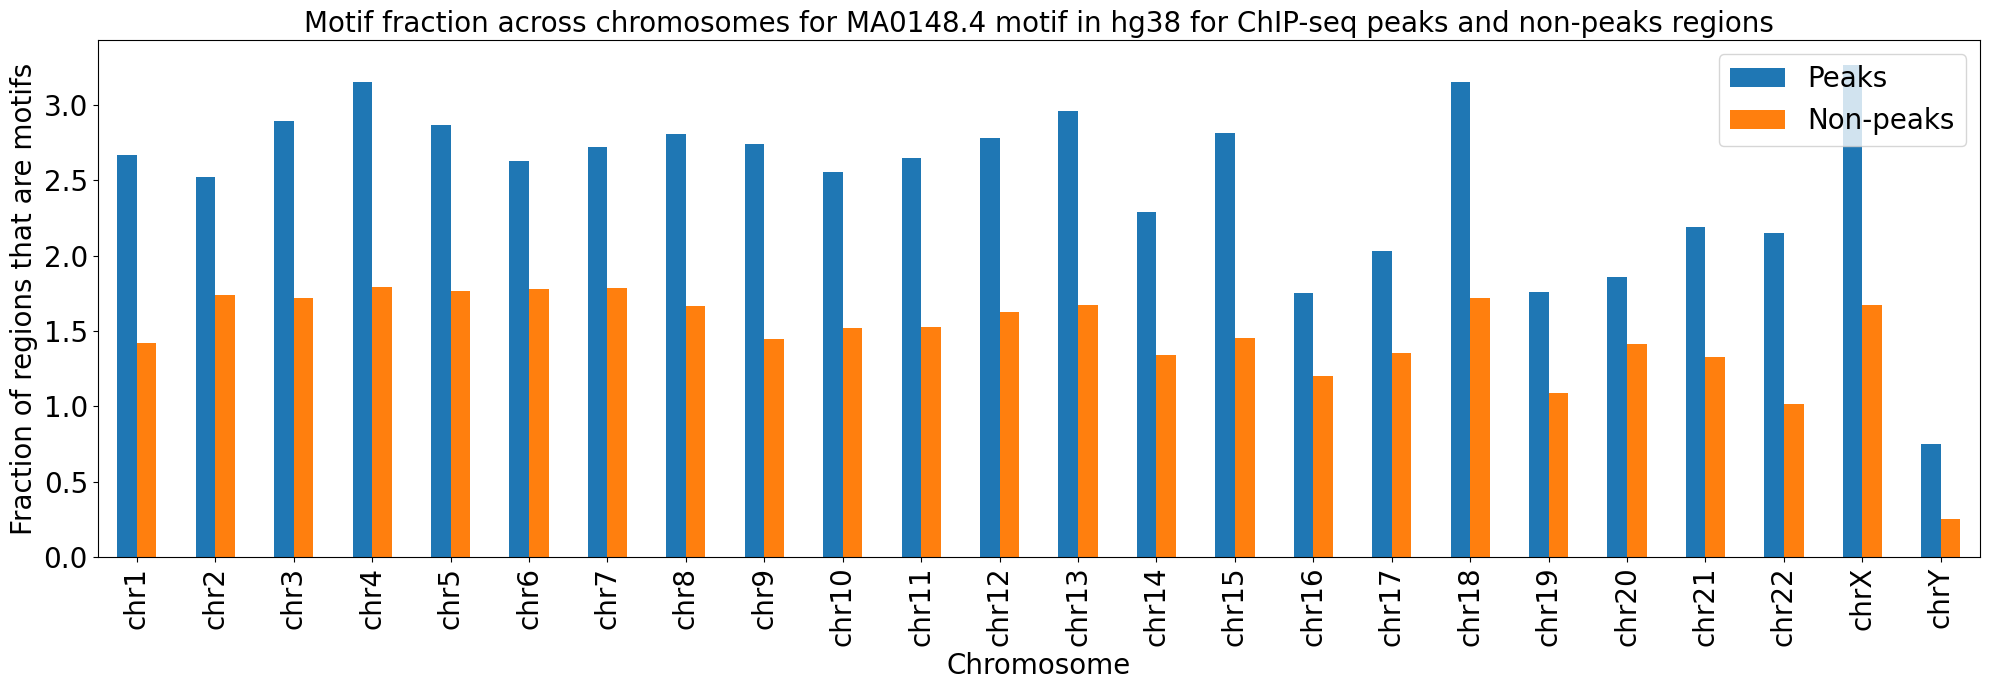

In [55]:
fig, ax = plt.subplots(figsize=(20, 7))

pd.DataFrame(
    {
        "Peaks": pd.Series(frac_peak)[np.argsort(chr_id)],
        "Non-peaks": pd.Series(frac_non_peak)[np.argsort(chr_id)],
    }
).plot.bar(ax=ax)

ax.set_xlabel("Chromosome", fontsize=20)
ax.set_ylabel("Fraction of regions that are motifs", fontsize=20)
ax.set_title(
    f"Motif fraction across chromosomes for {profile} motif in hg38 for ChIP-seq peaks and non-peaks regions",
    fontsize=20,
)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.legend(fontsize=20)
fig.tight_layout()


## Overlap between ATAC-seq peaks and ChIP-seq peaks

### First look at single position level

In [56]:
non_peak = {i: 0 for i in genome_size.chrom}
only_chip_peak = {i: 0 for i in genome_size.chrom}
only_atac_peak = {i: 0 for i in genome_size.chrom}
both_peak = {i: 0 for i in genome_size.chrom}
for i in tqdm(genome_size.itertuples(), total=genome_size.shape[0]):
    atac_peak_cover = np.zeros(i.size, dtype=bool)
    chip_peak_cover = np.zeros(i.size, dtype=bool)
    atac_bed_dedup_chr = atac_bed_dedup.query(f"chrom == '{i.chrom}'")
    chip_bed_dedup_chr = tf_bed_dedup.query(f"chrom == '{i.chrom}'")
    for j in atac_bed_dedup_chr.itertuples():
        atac_peak_cover[j.chromStart : j.chromEnd] = True
    for j in chip_bed_dedup_chr.itertuples():
        chip_peak_cover[j.chromStart : j.chromEnd] = True
    non_peak[i.chrom] = (~atac_peak_cover & ~chip_peak_cover).sum()
    only_atac_peak[i.chrom] = (atac_peak_cover & ~chip_peak_cover).sum()
    only_chip_peak[i.chrom] = (chip_peak_cover & ~atac_peak_cover).sum()
    both_peak[i.chrom] = (atac_peak_cover & chip_peak_cover).sum()


  0%|          | 0/25 [00:00<?, ?it/s]

In [57]:
frac_non_peak = {}
frac_only_atac_peak = {}
frac_only_chip_peak = {}
frac_both_peak = {}
for i in genome_size.itertuples():
    if only_atac_peak[i.chrom] == 0 or only_chip_peak[i.chrom] == 0:
        continue
    chr_length = genome_size.query(f"chrom == '{i.chrom}'")["size"].iloc[0]
    frac_non_peak[i.chrom] = non_peak[i.chrom] / chr_length
    frac_only_atac_peak[i.chrom] = only_atac_peak[i.chrom] / chr_length
    frac_only_chip_peak[i.chrom] = only_chip_peak[i.chrom] / chr_length
    frac_both_peak[i.chrom] = both_peak[i.chrom] / chr_length

chr_id = list(
    map(lambda x: int(x[3:]) if x[3:].isdigit() else ord(x[3:]), frac_peak.keys())
)

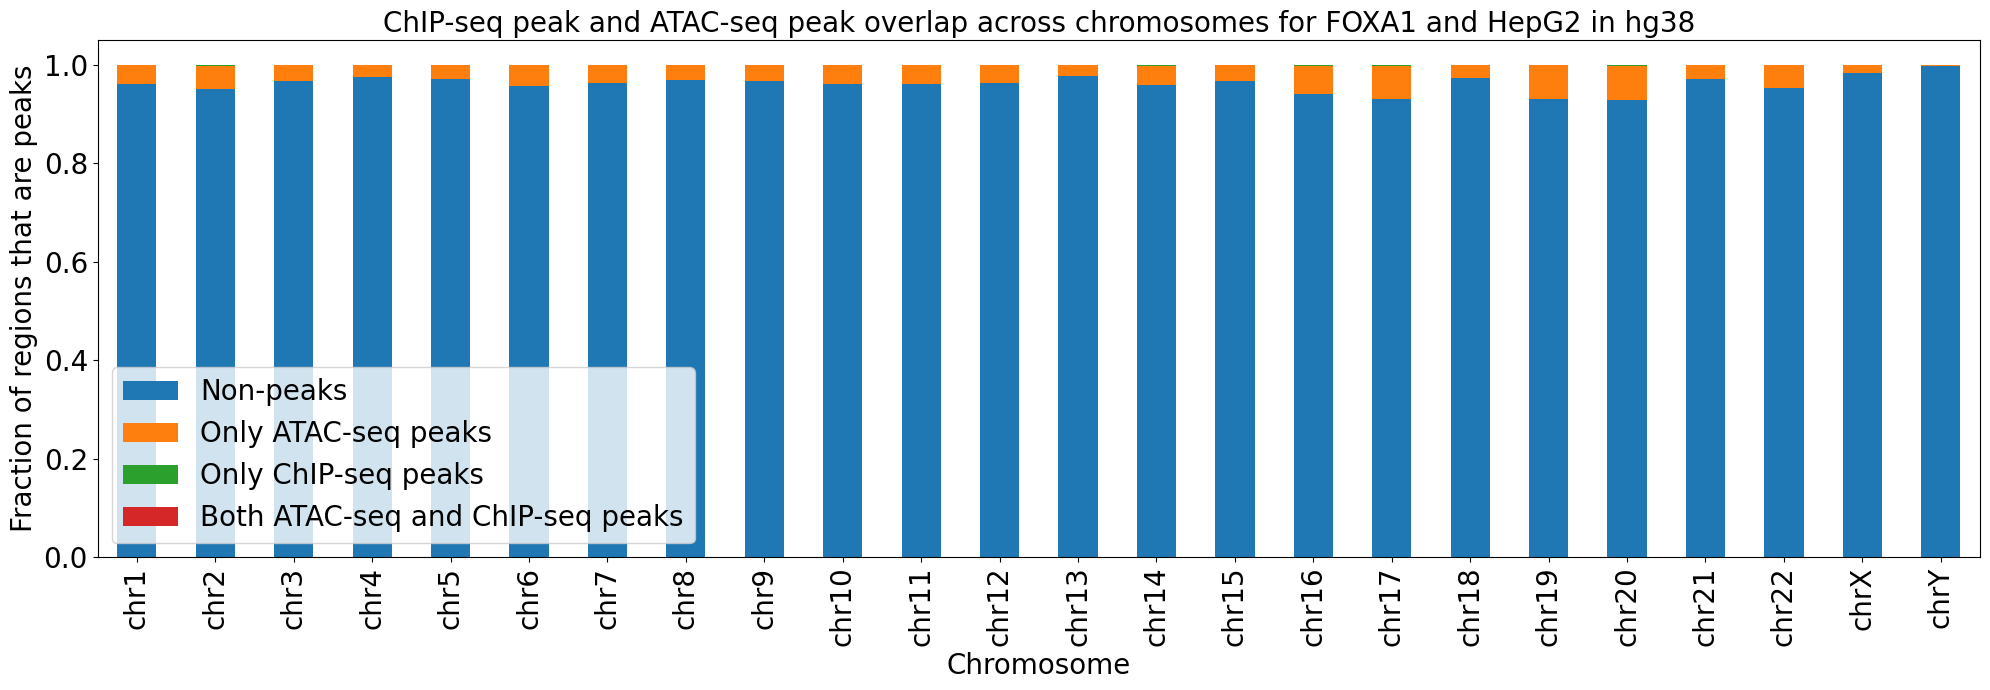

In [58]:
# This time, plot a stacked bar plot, and each bar will be of height 1
fig, ax = plt.subplots(figsize=(20, 7))

df_plot = pd.DataFrame(
    {
        "Non-peaks": pd.Series(frac_non_peak)[np.argsort(chr_id)],
        "Only ATAC-seq peaks": pd.Series(frac_only_atac_peak)[np.argsort(chr_id)],
        "Only ChIP-seq peaks": pd.Series(frac_only_chip_peak)[np.argsort(chr_id)],
        "Both ATAC-seq and ChIP-seq peaks": pd.Series(frac_both_peak)[
            np.argsort(chr_id)
        ],
    }
)

df_plot.plot.bar(ax=ax, stacked=True)

ax.set_xlabel("Chromosome", fontsize=20)
ax.set_ylabel("Fraction of regions that are peaks", fontsize=20)
ax.set_title(
    f"ChIP-seq peak and ATAC-seq peak overlap across chromosomes for {tf} and {cell_type} in hg38",
    fontsize=20,
)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.legend(fontsize=20)
fig.tight_layout()


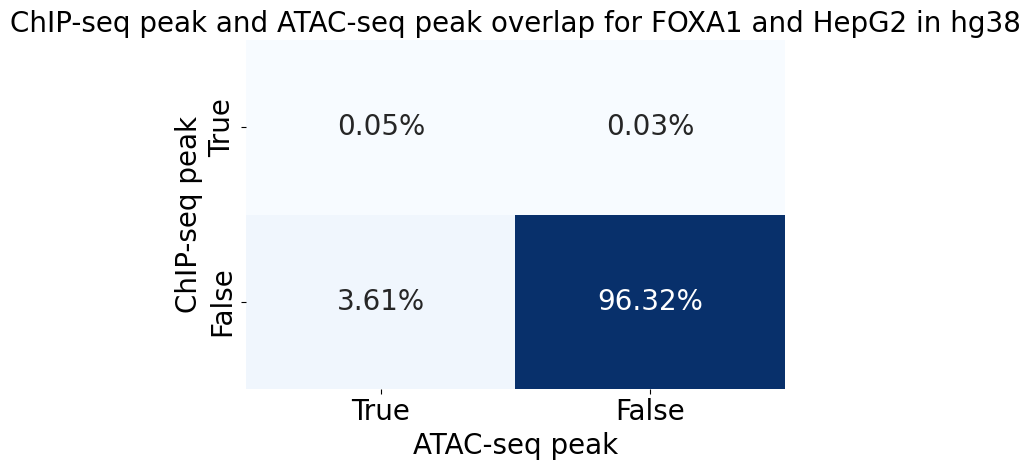

In [59]:
# it looks ugly. So let's try 2x2 heatmap (ignore chromosomes, do it in one go for the entire genome).
frac_non_peak = 0
frac_only_atac_peak = 0
frac_only_chip_peak = 0
frac_both_peak = 0

for i in genome_size.itertuples():
    if only_atac_peak[i.chrom] == 0 or only_chip_peak[i.chrom] == 0:
        continue
    frac_non_peak += non_peak[i.chrom]
    frac_only_atac_peak += only_atac_peak[i.chrom]
    frac_only_chip_peak += only_chip_peak[i.chrom]
    frac_both_peak += both_peak[i.chrom]

data_plot = np.array(
    [
        [frac_both_peak, frac_only_chip_peak],
        [frac_only_atac_peak, frac_non_peak],
    ]
)
data_plot = data_plot / data_plot.sum()

fig, ax = plt.subplots()

sns.heatmap(
    data_plot,
    annot=True,
    fmt=".2%",
    cmap="Blues",
    ax=ax,
    cbar=False,
    annot_kws={"size": 20},
)
ax.set_xticklabels(
    ["True", "False"], fontsize=20
)
ax.set_yticklabels(
    ["True", "False"], fontsize=20
)
ax.set_xlabel("ATAC-seq peak", fontsize=20)
ax.set_ylabel("ChIP-seq peak", fontsize=20)
ax.set_title(
    f"ChIP-seq peak and ATAC-seq peak overlap for {tf} and {cell_type} in hg38",
    fontsize=20,
)
fig.tight_layout()

In [60]:
# atac_peak = {i: 0 for i in genome_size.chrom}
chip_peak = {i: 0 for i in genome_size.chrom}
non_chip_peak = {i: 0 for i in genome_size.chrom}
chip_peak_atac = {i: 0 for i in genome_size.chrom}
non_chip_peak_atac = {i: 0 for i in genome_size.chrom}
for i in tqdm(genome_size.itertuples(), total=genome_size.shape[0]):
    atac_peak_cover = np.zeros(i.size, dtype=bool)
    # chip_peak_cover = np.zeros(i.size, dtype=bool)
    atac_bed_dedup_chr = atac_bed_dedup.query(f"chrom == '{i.chrom}'")
    for j in atac_bed_dedup_chr.itertuples():
        atac_peak_cover[j.chromStart : j.chromEnd] = True
    # for j in chip_bed_dedup_chr.itertuples():
    #     chip_peak_cover[j.chromStart : j.chromEnd] = True
    # for j in atac_bed_dedup_chr.itertuples():
    #     if np.any(chip_peak_cover[j.chromStart : j.chromEnd]):
    #         atac_peak_chip[i.chrom] += 1
    chip_bed_dedup_chr = tf_bed_dedup.query(f"chrom == '{i.chrom}'")
    chip_bed_bg_chr = sample_background_regions(chip_bed_dedup_chr, i.size, factor=2)
    chip_peak[i.chrom] = chip_bed_dedup_chr.shape[0]
    non_chip_peak[i.chrom] = chip_bed_bg_chr.shape[0]
    for j in chip_bed_dedup_chr.itertuples():
        if np.any(atac_peak_cover[j.chromStart : j.chromEnd]):
            chip_peak_atac[i.chrom] += 1
    for j in chip_bed_bg_chr.itertuples():
        if np.any(atac_peak_cover[j.chromStart : j.chromEnd]):
            non_chip_peak_atac[i.chrom] += 1


  0%|          | 0/25 [00:00<?, ?it/s]

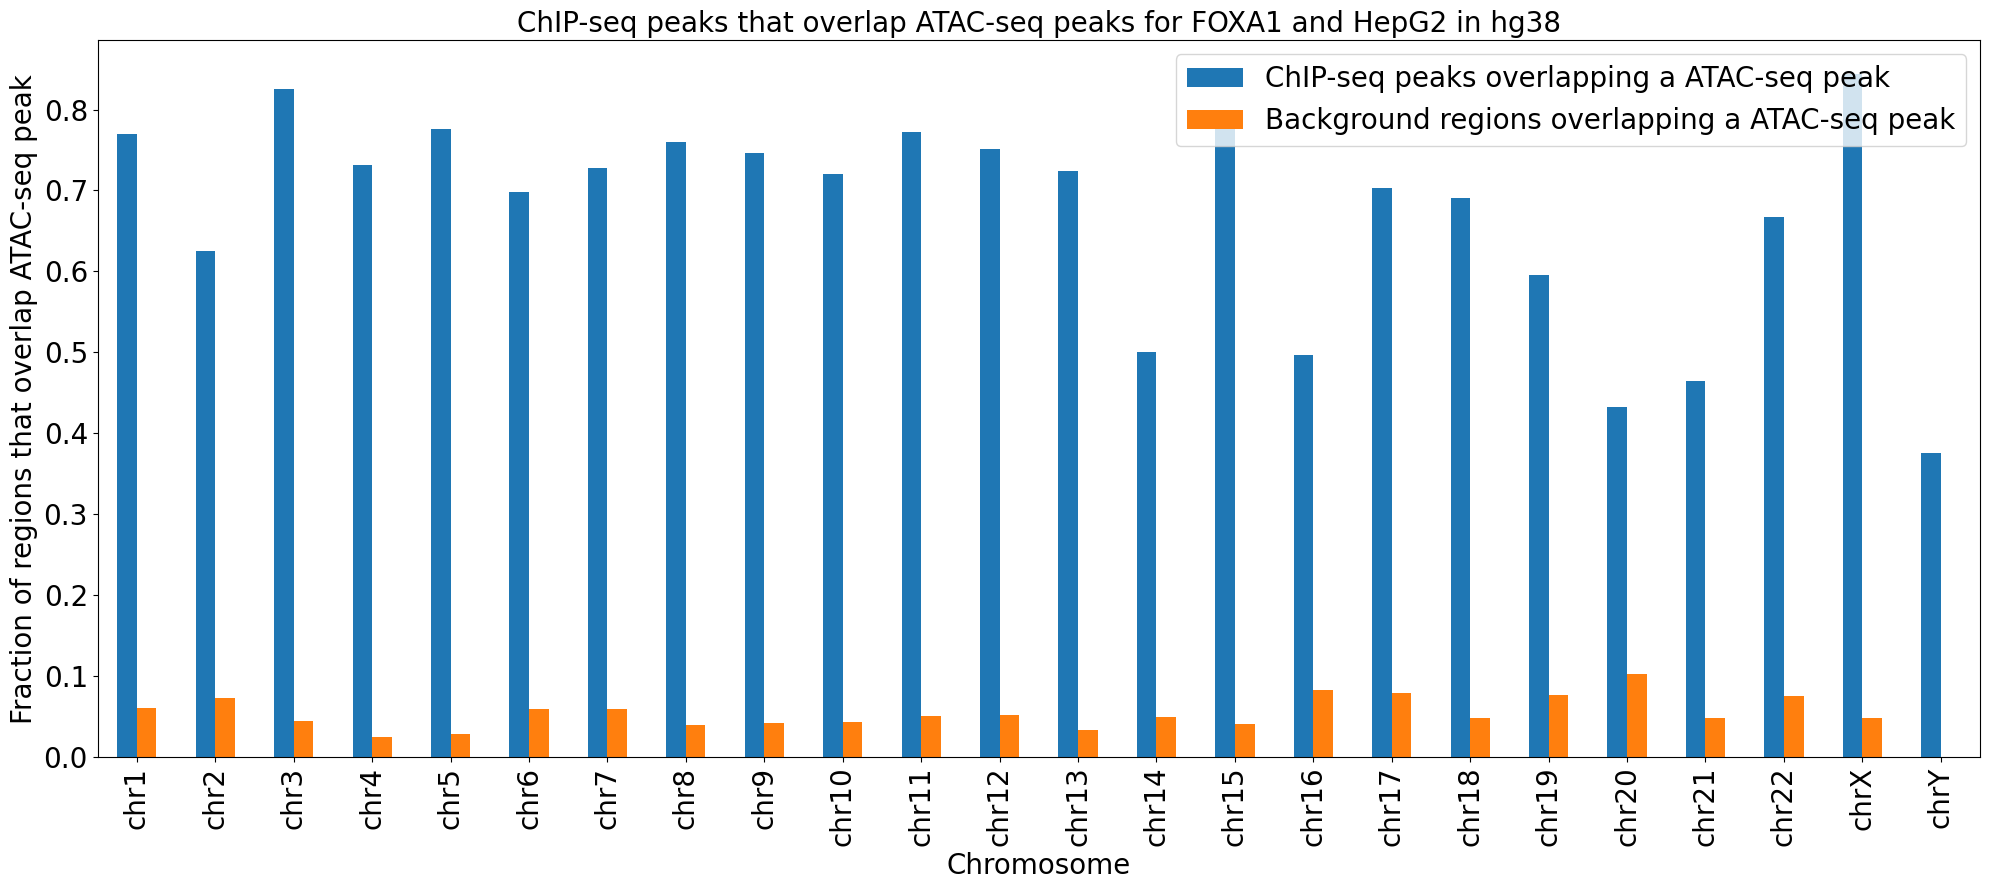

In [61]:
frac_peak = {}
frac_non_peak = {}
for i in genome_size.itertuples():
    if chip_peak[i.chrom] == 0:
        continue
    frac_peak[i.chrom] = chip_peak_atac[i.chrom] / chip_peak[i.chrom]
    frac_non_peak[i.chrom] = non_chip_peak_atac[i.chrom] / non_chip_peak[i.chrom]

chr_id = list(
    map(lambda x: int(x[3:]) if x[3:].isdigit() else ord(x[3:]), frac_peak.keys())
)

fig, ax = plt.subplots(figsize=(20, 9))
pd.DataFrame(
    {
        "ChIP-seq peaks overlapping a ATAC-seq peak": pd.Series(frac_peak)[np.argsort(chr_id)],
        "Background regions overlapping a ATAC-seq peak": pd.Series(frac_non_peak)[
            
            np.argsort(chr_id)
        ],
    }
).plot.bar(ax=ax)

ax.set_xlabel("Chromosome", fontsize=20)
ax.set_ylabel("Fraction of regions that overlap ATAC-seq peak", fontsize=20)
ax.set_title(
    f"ChIP-seq peaks that overlap ATAC-seq peaks for {tf} and {cell_type} in hg38",
    fontsize=20,
)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.legend(fontsize=20)
fig.tight_layout()


## Effectiveness of predicting ChIP-seq peak from ATAC-seq peak with motif

In [62]:
atac_peak = {i: 0 for i in genome_size.chrom}
atac_peak_chip_only = {i: 0 for i in genome_size.chrom}
atac_peak_motif_only = {i: 0 for i in genome_size.chrom}
atac_peak_both = {i: 0 for i in genome_size.chrom}
for i in tqdm(genome_size.itertuples(), total=genome_size.shape[0]):
    chip_peak_cover = np.zeros(i.size, dtype=bool)
    motif_pos_cover = np.zeros(i.size, dtype=bool)
    motif_neg_cover = np.zeros(i.size, dtype=bool)

    atac_bed_dedup_chr = atac_bed_dedup.query(f"chrom == '{i.chrom}'")
    chip_bed_dedup_chr = tf_bed_dedup.query(f"chrom == '{i.chrom}'")
    motif_pos_bed_chr = motif_pos_bed.query(f"chrom == '{i.chrom}'")
    motif_neg_bed_chr = motif_neg_bed.query(f"chrom == '{i.chrom}'")
    for j in chip_bed_dedup_chr.itertuples():
        chip_peak_cover[j.chromStart : j.chromEnd] = True
    for j in motif_pos_bed_chr.itertuples():
        motif_pos_cover[j.chromStart] = True
    for j in motif_neg_bed_chr.itertuples():
        motif_neg_cover[j.chromStart] = True
    motif_either_cover = np.logical_or(motif_pos_cover, motif_neg_cover)
    motif_only = 0
    chip_only = 0
    both = 0
    for j in atac_bed_dedup_chr.itertuples():
        if np.any(chip_peak_cover[j.chromStart : j.chromEnd]):
            if np.any(motif_either_cover[j.chromStart : j.chromEnd - motif_length]):
                both += 1
            else:
                chip_only += 1
        elif np.any(motif_either_cover[j.chromStart : j.chromEnd - motif_length]):
                motif_only += 1
    atac_peak[i.chrom] = atac_bed_dedup_chr.shape[0]
    atac_peak_chip_only[i.chrom] = chip_only
    atac_peak_motif_only[i.chrom] = motif_only
    atac_peak_both[i.chrom] = both


  0%|          | 0/25 [00:00<?, ?it/s]

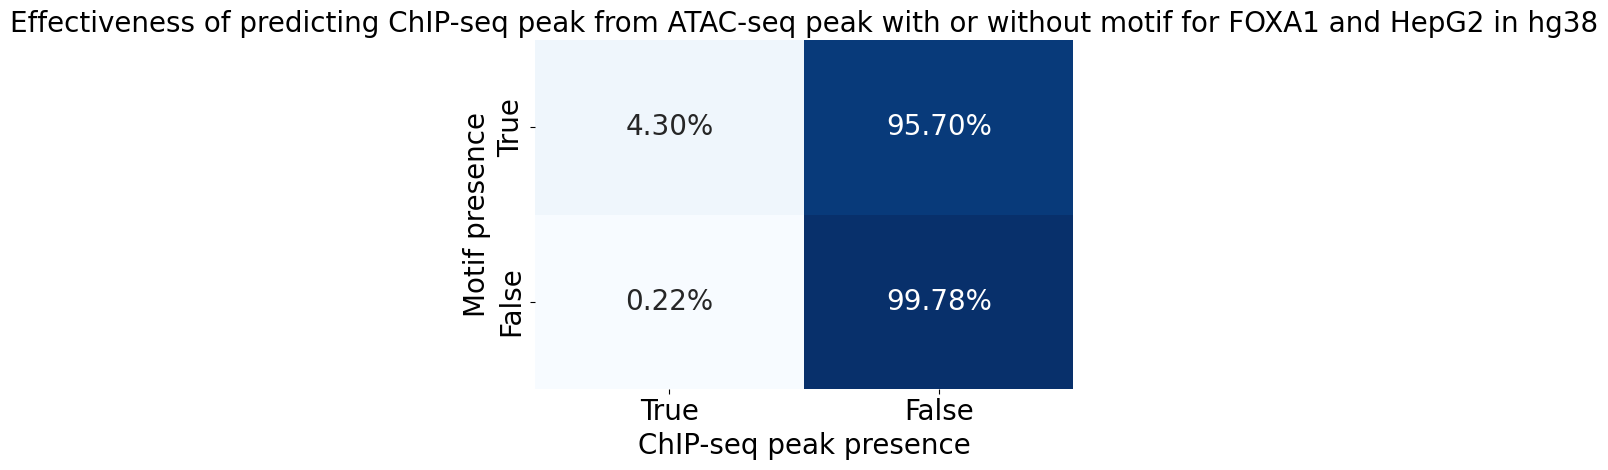

In [63]:
frac_chip_only = 0
frac_motif_only = 0
frac_both = 0
frac_neither = 0
for i in genome_size.itertuples():
    if atac_peak[i.chrom] == 0:
        continue
    frac_chip_only += atac_peak_chip_only[i.chrom]
    frac_motif_only += atac_peak_motif_only[i.chrom]
    frac_both += atac_peak_both[i.chrom]
    frac_neither += (
        atac_peak[i.chrom]
        - atac_peak_chip_only[i.chrom]
        - atac_peak_motif_only[i.chrom]
        - atac_peak_both[i.chrom]
    )

data_plot = np.array(
    [
        [frac_both, frac_motif_only],
        [frac_chip_only, frac_neither],
    ]
)

data_plot = data_plot / data_plot.sum(axis=1, keepdims=True)

fig, ax = plt.subplots()
sns.heatmap(
    data_plot,
    annot=True,
    fmt=".2%",
    cmap="Blues",
    ax=ax,
    cbar=False,
    xticklabels=["True", "False"],
    yticklabels=["True", "False"],
    annot_kws={"fontsize": 20},
)
ax.set_xlabel("ChIP-seq peak presence", fontsize=20)
ax.set_ylabel("Motif presence", fontsize=20)
ax.set_title(
    f"Effectiveness of predicting ChIP-seq peak from ATAC-seq peak with or without motif for {tf} and {cell_type} in hg38",
    fontsize=20,
)
ax.tick_params(axis="both", which="major", labelsize=20)
fig.tight_layout()

## Are ChIP-seq peaks associated with high ATAC-seq signal?

In [64]:
import pyBigWig

In [65]:
atac_track_data_dir = f"./data/{cell_type}/ATAC-seq"
atac_track_data_path = [
    f"{atac_track_data_dir}/{i}"
    for i in os.listdir(atac_track_data_dir)
    if i.endswith(".bigWig")
][0]
atac_track = pyBigWig.open(atac_track_data_path)

In [66]:
atac_track_meta = atac_track.chroms()

In [67]:
atac_signal_peak = {i: [] for i in genome_size.chrom}
atac_signal_bg = {i: [] for i in genome_size.chrom}
for i in tqdm(genome_size.itertuples(), total=genome_size.shape[0]):
    if i.chrom not in atac_track_meta:
        continue
    chip_bed_dedup_chr = tf_bed_dedup.query(f"chrom == '{i.chrom}'")
    chip_bed_bg_chr = sample_background_regions(chip_bed_dedup_chr, i.size)
    atac_signal = atac_track.values(i.chrom, 0, i.size)
    for j in chip_bed_dedup_chr.itertuples():
        atac_signal_peak[i.chrom].append(
            np.mean(atac_signal[j.chromStart : j.chromEnd])
        )
    for j in chip_bed_bg_chr.itertuples():
        atac_signal_bg[i.chrom].append(
            np.mean(atac_signal[j.chromStart : j.chromEnd])
        )


  0%|          | 0/25 [00:00<?, ?it/s]

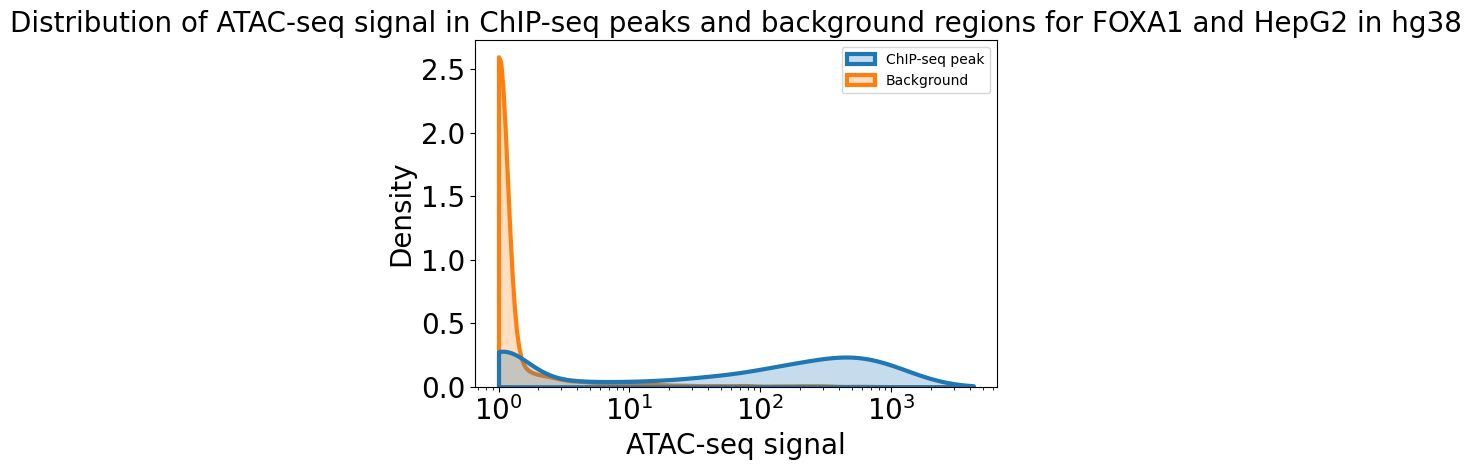

In [68]:
# plot two distributions
atac_signal_peak_collect = np.array([j for i in atac_signal_peak.values() for j in i])
atac_signal_bg_collect = np.array([j for i in atac_signal_bg.values() for j in i])
fig, ax = plt.subplots()
sns.kdeplot(
    {
        "ChIP-seq peak": atac_signal_peak_collect + 1,
        "Background": atac_signal_bg_collect + 1,
    },
    linewidth=3,
    label="Background",
    fill=True,
    ax=ax,
    cut=0,
    log_scale=True,
)
ax.set_xlabel("ATAC-seq signal", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.set_title(
    f"Distribution of ATAC-seq signal in ChIP-seq peaks and background regions for {tf} and {cell_type} in hg38",
    fontsize=20,
)
ax.tick_params(axis="both", which="major", labelsize=20)
fig.tight_layout()
